# Mercari Price Suggestion Challenge

About - Mercari is the selling application where we can sell (or buy) almost anything. We all have stuff that we don't use, but that stuff still has value. Mercari helps us sell it, ship it, and earn some cash.

## Business Problem

Pricing is a very important element when any product gets listed on the marketplace. If your prices are too high, you will meet with great resistance to buying. If your prices are too low, you may also meet with resistance because of perceived quality issues, and you probably won't make any money on the sales you have. It can be hard to know how much something's really worth. Small details can mean big differences in pricing.


For example, one of these pullovers cost \\$160 and the other cost \$23.99. Can you guess which one's which?

> Levi's Long-Sleeve Pullover Hoodie, Black, Men's, Size L, Great Condition

> Nike's Long-Sleeve Pullover Hoodie, Size L, Great Condition

Mercari which is similar to ebay(or olx) would like to offer pricing suggestions to sellers while listing their products on it's marketplace.

## Why machine learning is a solution?

Determining how customers will react is quite complex. There are many factors that come into play such as season, rivalry, demand, etc. These are just a few. ML algorithms can learn patterns from data and detect emerging trends or new demands. Machine learning can be used to optimise price with higher accuracy.

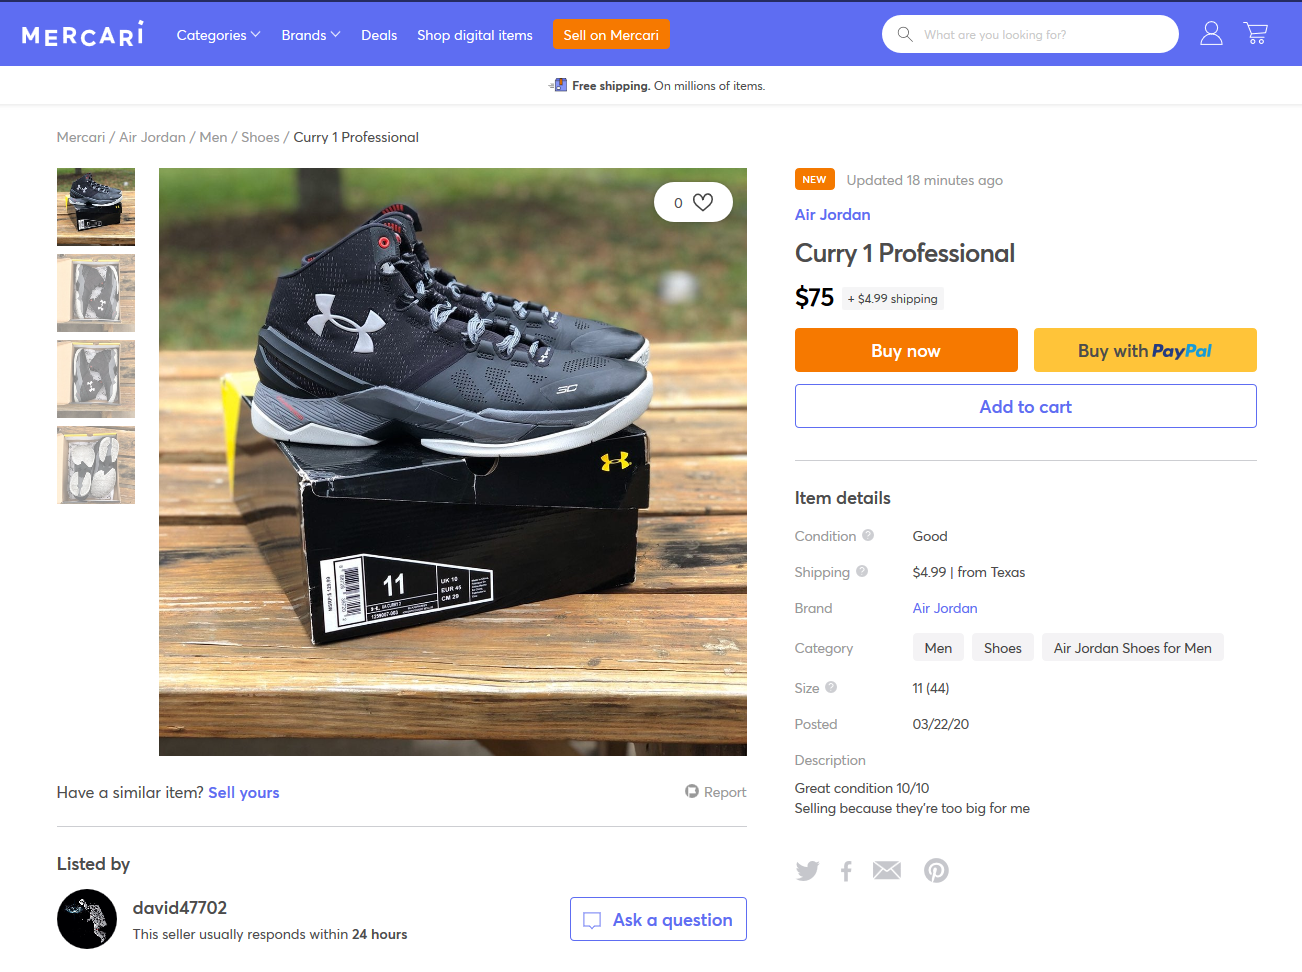

In [1]:
# This is the product page on Mercari,Inc

from IPython.display import Image
Image('mercari-product-page.png')

## Data

We have been given train.tsv.

The files consist of a list of product listings. These files are tab-delimited.

1. train_id or test_id - the id of the listing. Example: `1`

2. name - the title of the listing. Example: `Razer BlackWidow Chroma Keyboard`

3. item_condition_id - the condition of the items provided by the seller. Lower the number, better the condition. Example: `3`

4. category_name - category of the listing. Example: `Electronics/Computers & Tablets/Components`

5. brand_name - brand of the listing. Example: `Razer`

6. price - the price that the item was sold for. This is the target variable that we need to predict. The unit is USD. Example: `52`

7. shipping - 1 if shipping fee is paid by seller and 0 by buyer. Example: `0`

8. item_description - the full description of the item. Example: `This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.`

As we need to predict price for a give product, We are solving regression problem. In real world, Mercari might will be having time series data with other features like geo location, history of purchases, etc. We are given text data and some numerical and categorical features.

There are two test files. There is no TARGET variable column in these files. These are used to calculate score on kaggle.
1. test.tsv
2. test_st2.tsv

## Evaluation Metric: RMSLE

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as

$\epsilon = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (log(p_{i}+1)-log(a_{i}+1))^2}$

Where:
- $\epsilon$ is the RMSLE value
- n is the total number of observations in the data set,
- p_{i} is your prediction of price, and
- a_{i} is the actual sale price for i
- log(x) is the natural logarithm of x

## Constraints

- Latency as we need to provide price suggestions at real time
- Interpretability
- We might need to train models weekly

## Imports

We are using typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`, `seaborn`

In [2]:
# Reload modules
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#supress warnings
import warnings
warnings.filterwarnings('ignore')

#numpy and pandas for data manipulation
import pandas as pd
import numpy as np
from numpy import median
from scipy.stats import norm
import re
import math

#matplotlib and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set(style='darkgrid')

import plotly
from plotly.offline import iplot
import plotly.graph_objects as go
from wordcloud import WordCloud

#file system management
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
import joblib

import keras
import tensorflow as tf
from keras import optimizers, callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers import Input, Dropout, Dense

seed = 42

Using TensorFlow backend.


## Read the Data

There are total of 5 files: 1 main file for training, 1 main file for testing, 1 example submission file, 1 file for testing in stage 2 and 1 example submission file for stage 2.

In [4]:
#Training data
df = pd.read_table('train.tsv')

print('Training data shape: ', df.shape)

Training data shape:  (1482535, 8)


The training data has 1482535 observations and 8 features inclusing `TARGET`

In [5]:
df.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

## Exploratory Data Analysis

## Examine Missing Values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [7]:
(df.isna().sum() / df.shape[0]) * 100

train_id              0.000000
name                  0.000000
item_condition_id     0.000000
category_name         0.426769
brand_name           42.675687
price                 0.000000
shipping              0.000000
item_description      0.000270
dtype: float64

The columns brand_name, category_name and item_description has missing values. We will have to fill in these missing values which is known as imputation. 42.67% of brand_name values are missing.

In [8]:
df.describe(include='all')

train_id     name  item_condition_id  \
count   1.482535e+06  1482535       1.482535e+06   
unique           NaN  1225273                NaN   
top              NaN   Bundle                NaN   
freq             NaN     2232                NaN   
mean    7.412670e+05      NaN       1.907380e+00   
std     4.279711e+05      NaN       9.031586e-01   
min     0.000000e+00      NaN       1.000000e+00   
25%     3.706335e+05      NaN       1.000000e+00   
50%     7.412670e+05      NaN       2.000000e+00   
75%     1.111900e+06      NaN       3.000000e+00   
max     1.482534e+06      NaN       5.000000e+00   

                                         category_name brand_name  \
count                                          1476208     849853   
unique                                            1287       4809   
top     Women/Athletic Apparel/Pants, Tights, Leggings       PINK   
freq                                             60177      54088   
mean                                               NaN        NaN   
std                                                NaN        NaN   
min                                                NaN        NaN   
25%                                                NaN        NaN   
50%                                                NaN        NaN   
75%                                                NaN        NaN   
max                                                NaN        NaN   

               price      shipping    item_description  
count   1.482535e+06  1.482535e+06             1482531  
unique           NaN           NaN             1281426  
top              NaN           NaN  No description yet  
freq             NaN           NaN               82489  
mean    2.673752e+01  4.472744e-01                 NaN  
std     3.858607e+01  4.972124e-01                 NaN  
min     0.000000e+00  0.000000e+00                 NaN  
25%     1.000000e+01  0.000000e+00                 NaN  
50%     1.700000e+01  0.000000e+00                 NaN  
75%     2.900000e+01  1.000000e+00                 NaN  
max     2.009000e+03  1.000000e+00                 NaN

- Most of the names are unique
- Top brand is PINK
- Top category is Women's clothing
- 'No description yet' is the most common product description. We can replace it with the name.

## Duplicates

Redundant rows can be dropped

In [9]:
duplicateRows = df[df.duplicated(['name', 'item_condition_id', 'category_name', 'brand_name', 'shipping', 'price', 'item_description'])]

duplicateRows[:4]

train_id                                      name  item_condition_id  \
185890    185890  3 IPhone 6/6S Tempered Glass Screen Prot                  1   
332528    332528                           Rose Gold Slime                  1   
380148    380148                    30 pcs Shipping Labels                  1   
443464    443464            NYX MATTE FINISH SETTING SPRAY                  1   

                                            category_name brand_name  price  \
185890  Electronics/Cell Phones & Accessories/Screen P...        NaN   10.0   
332528                            Kids/Toys/Arts & Crafts     Elmers    5.0   
380148            Other/Office supplies/Shipping Supplies        NaN    6.0   
443464                                 Beauty/Makeup/Face        NYX   10.0   

        shipping                                   item_description  
185890         1  • iPhone 6 or 6S Tempered Glass Protector • 9H...  
332528         1  Very stretchy 2oz Made to order COMES WITH BOR...  
380148         1  These are Self Adhesive Shipping Stickers with...  
443464         1  For that fresh matte look that lasts, the NYX ...

In [10]:
df[(df.name == 'Rose Gold Slime') & (df.price == 5.0)]

train_id             name  item_condition_id            category_name  \
76794      76794  Rose Gold Slime                  1  Kids/Toys/Arts & Crafts   
332528    332528  Rose Gold Slime                  1  Kids/Toys/Arts & Crafts   

       brand_name  price  shipping  \
76794      Elmers    5.0         1   
332528     Elmers    5.0         1   

                                         item_description  
76794   Very stretchy 2oz Made to order COMES WITH BOR...  
332528  Very stretchy 2oz Made to order COMES WITH BOR...

In [11]:
df[(df.name == '30 pcs Shipping Labels') & (df.price == 6.0)]

train_id                    name  item_condition_id  \
302884     302884  30 pcs Shipping Labels                  1   
380148     380148  30 pcs Shipping Labels                  1   
938745     938745  30 pcs Shipping Labels                  1   
1032697   1032697  30 pcs Shipping Labels                  1   

                                   category_name brand_name  price  shipping  \
302884   Other/Office supplies/Shipping Supplies        NaN    6.0         1   
380148   Other/Office supplies/Shipping Supplies        NaN    6.0         1   
938745   Other/Office supplies/Shipping Supplies        NaN    6.0         1   
1032697  Other/Office supplies/Shipping Supplies        NaN    6.0         1   

                                          item_description  
302884   These are Self Adhesive Shipping Stickers with...  
380148   These are Self Adhesive Shipping Stickers with...  
938745   These are Self Adhesive Shipping Stickers Thes...  
1032697  These are Self Adhesive Shipping Stickers Thes...

In [12]:
df[(df.name == 'NYX MATTE FINISH SETTING SPRAY') & (df.price == 10.0)]

train_id                            name  item_condition_id  \
273434    273434  NYX MATTE FINISH SETTING SPRAY                  1   
443464    443464  NYX MATTE FINISH SETTING SPRAY                  1   

             category_name brand_name  price  shipping  \
273434  Beauty/Makeup/Face        NYX   10.0         1   
443464  Beauty/Makeup/Face        NYX   10.0         1   

                                         item_description  
273434  For that fresh matte look that lasts, the NYX ...  
443464  For that fresh matte look that lasts, the NYX ...

- There are 49 products which are repeated in the dataset. We will drop those.
- There are also many products which differs in product description and rest of the information is similar. We will keep these. 

### Examine the Distribution of Target Variable - Price

In [13]:
df.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

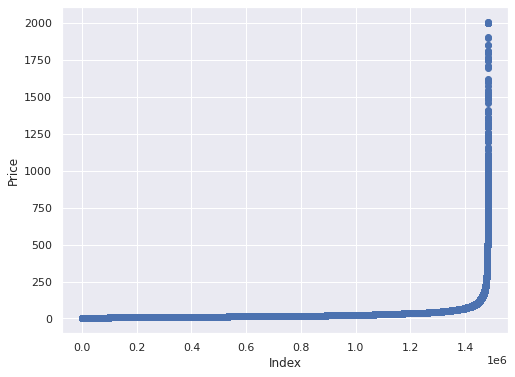

In [14]:
plt.figure(figsize = (8,6))
plt.scatter(range(df.shape[0]), np.sort(df.price.values))
plt.xlabel('Index', fontsize = 12)
plt.ylabel('Price', fontsize = 12)
plt.show()

In [15]:
print('Number of products with price less than $3 -', df['price'][df['price'] < 3].count())
print('Number of products with price greater than $2000 -', df['price'][df['price'] > 2000].count())

Number of products with price less than $3 - 874
Number of products with price greater than $2000 - 3


There seems to be some outliers in the data on the upper side and there are products with price as \\$0. According to Mercari Pricing tips - Items can be priced between \\$3 - \\$2,000. So there are several products with price less than \\$3 and few have price more than \\$2000. So we will remove 877 rows.

In [16]:
df = df[(df.price >= 3) & (df.price <= 2000)]

We removed all the rows (i.e 877) where price is less than \\$3 and greater than \$2000.

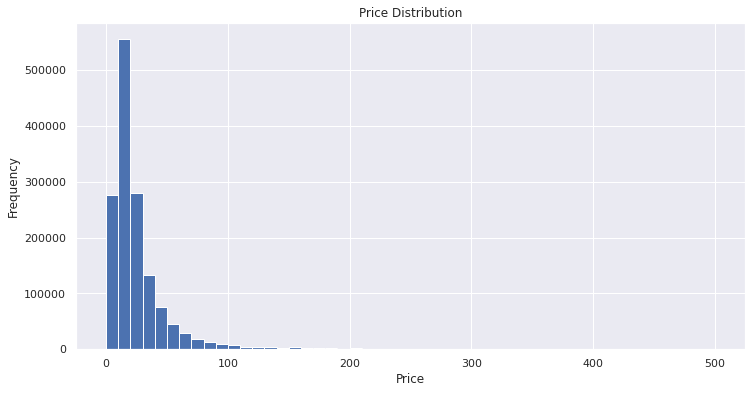

In [17]:
df['price'].plot.hist(bins=50, figsize=(12,6), edgecolor='white', range=[0,500])
plt.title('Price Distribution', fontsize=12)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

Price distribution is positively skewed. Max values lie between \\$3 and \\$100. Mean price in the training set is about \$267. We will take the logarithm to see if the Log(price) is normally distributed or not.

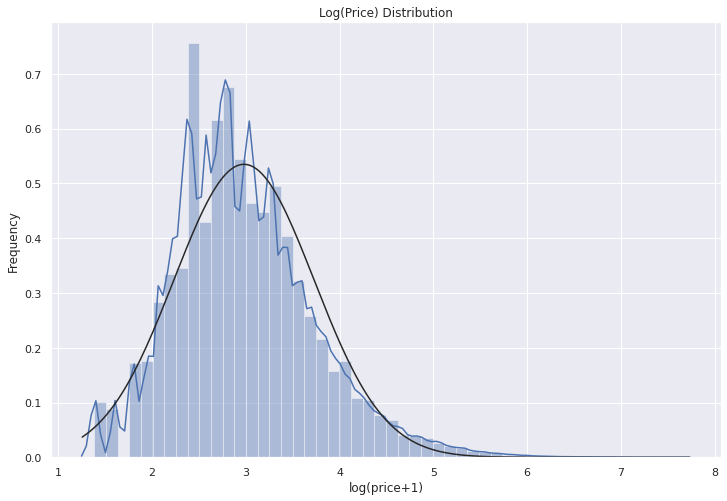

In [18]:
plt.figure(figsize=(12, 8))
sns.distplot(np.log1p(df['price']), bins=50, kde=True, fit=norm)
plt.title('Log(Price) Distribution', fontsize=12)
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

After taking logarithm of target variable `Price`, it appears to be almost normally distributed.

In [19]:
df.price.describe(percentiles = [0.8, 0.9, 0.95, 0.99])

count    1.481658e+06
mean     2.674928e+01
std      3.848908e+01
min      3.000000e+00
50%      1.700000e+01
80%      3.400000e+01
90%      5.100000e+01
95%      7.500000e+01
99%      1.700000e+02
max      2.000000e+03
Name: price, dtype: float64

- 95% of the items are priced below \\$75
- 99% of the items are priced below \\$170
- 1% of the products might be outliers or some expensive products
- Median price is \\$17 

In [20]:
#Create a new feature - log(price)
df['log_price'] = np.log1p(df['price'])

## Univariate and Multivariate Analysis

### Shipping

In [21]:
df['shipping'].value_counts()

0    818873
1    662785
Name: shipping, dtype: int64

- Count of products with shipping equals 0 (or shipping fee paid by buyer) is greater

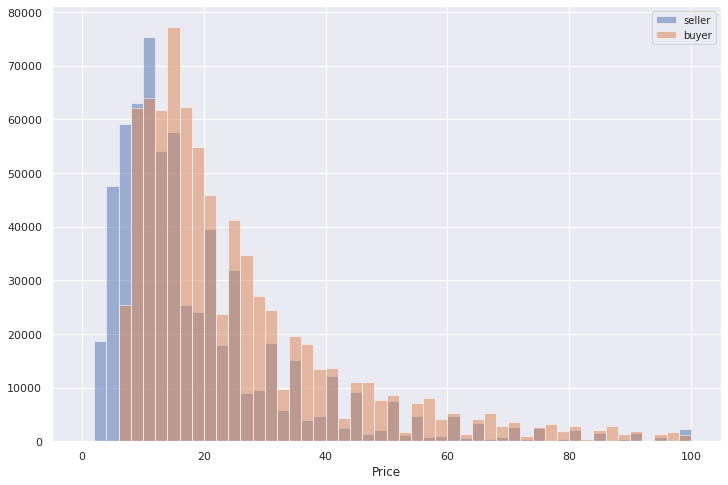

In [22]:
shipping_buyer = df[df['shipping'] == 0]['price']
shipping_seller = df[df['shipping'] == 1]['price']

plt.figure(figsize=(12, 8))
plt.hist(shipping_seller, alpha=0.5, bins=50, range=[0,100], label='seller')
plt.hist(shipping_buyer, alpha=0.5, bins=50, range=[0,100], label='buyer')
plt.xlabel('Price')
plt.legend(fontsize = 10)
plt.show()

In [23]:
print('Median price when shipping is paid by seller is ${}'.format(shipping_seller.median()))
print('Median price when shipping is paid by buyer is ${}'.format(shipping_buyer.median()))

Median price when shipping is paid by seller is $14.0
Median price when shipping is paid by buyer is $20.0


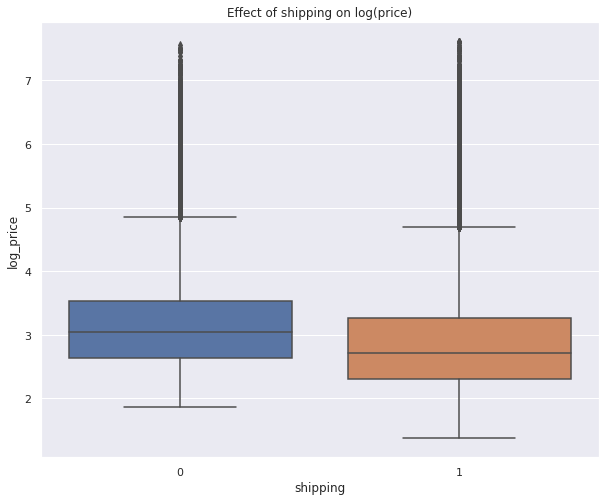

In [24]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='shipping', y='log_price', data=df)
plt.title('Effect of shipping on log(price)')
plt.show()

- Price of products are a bit more when the shipping is paid by buyer than seller. It explains that buyer pay more shipping fee and the total product cost goes up.

### Brand

In [25]:
df.brand_name.isnull().sum()

632336

In [26]:
df.brand_name.value_counts()[0:11]

PINK                 54072
Nike                 54006
Victoria's Secret    48011
LuLaRoe              30995
Apple                17314
FOREVER 21           15178
Nintendo             14998
Lululemon            14550
Michael Kors         13916
American Eagle       13245
Rae Dunn             12300
Name: brand_name, dtype: int64

In [27]:
df[(df.brand_name == 'Vitamix') | (df.brand_name == 'Celine')]

train_id                                     name  item_condition_id  \
2569         2569                  Phantom Trapeze Handbag                  2   
15769       15769    Celine Tri Colored Suede Mini luggage                  3   
32553       32553                     Vitamix 5200 blender                  1   
59329       59329   Trapeze Bag Céline Trapèze Black Other                  2   
79781       79781                       Celine Purse (New)                  1   
...           ...                                      ...                ...   
1403123   1403123           HIGH WAISTED SHORTS SIZE LARGE                  2   
1432930   1432930  Authentic Vintage Celine Drawstring bag                  3   
1445374   1445374  2 flat Celine 2 tones with 1 new Audrey                  2   
1460847   1460847         Blue Celine Phantom Largest Size                  2   
1465701   1465701    Celine large zip multifunction wallet                  1   

                                             category_name brand_name   price  \
2569               Women/Women's Handbags/Totes & Shoppers     Celine    70.0   
15769              Women/Women's Handbags/Totes & Shoppers     Celine  1009.0   
32553    Home/Kitchen & Dining/Food Service Equipment &...    Vitamix   300.0   
59329                  Women/Women's Handbags/Shoulder Bag     Celine   244.0   
79781                  Women/Women's Handbags/Shoulder Bag     Celine   116.0   
...                                                    ...        ...     ...   
1403123             Vintage & Collectibles/Clothing/Shorts     Celine    14.0   
1432930                Women/Women's Handbags/Shoulder Bag     Celine   186.0   
1445374               Women/Women's Accessories/Sunglasses     Celine   336.0   
1460847            Women/Women's Handbags/Totes & Shoppers     Celine   334.0   
1465701                  Women/Women's Accessories/Wallets     Celine   366.0   

         shipping                                   item_description  \
2569            0  NWOT; black vegan leather Phantom Trapeze larg...   
15769           0  Beautiful Celine mini luggage. In good conditi...   
32553           1                             This item is brand new   
59329           0  This is an authentic CELINE Drummed Calfskin S...   
79781           0  Brand New Celine Purse, with long strap to car...   
...           ...                                                ...   
1403123         0  Please make me an ofder. These have never been...   
1432930         1  Pre-loved Authentic Celine draw string bag wit...   
1445374         0  2 new flat two tones Celine. With 1 new Audrey...   
1460847         0  Pictured next to Hermes Birkin 40 for size ref...   
1465701         0  Brand new in box, never used. Includes all tag...   

         log_price  
2569      4.262680  
15769     6.917706  
32553     5.707110  
59329     5.501258  
79781     4.762174  
...            ...  
1403123   2.708050  
1432930   5.231109  
1445374   5.820083  
1460847   5.814131  
1465701   5.905362  

[82 rows x 9 columns]

In [28]:
df['has_brand_name'] = (df['brand_name'].isna()).astype(np.int8) #if brand_name is present, 0 else 1

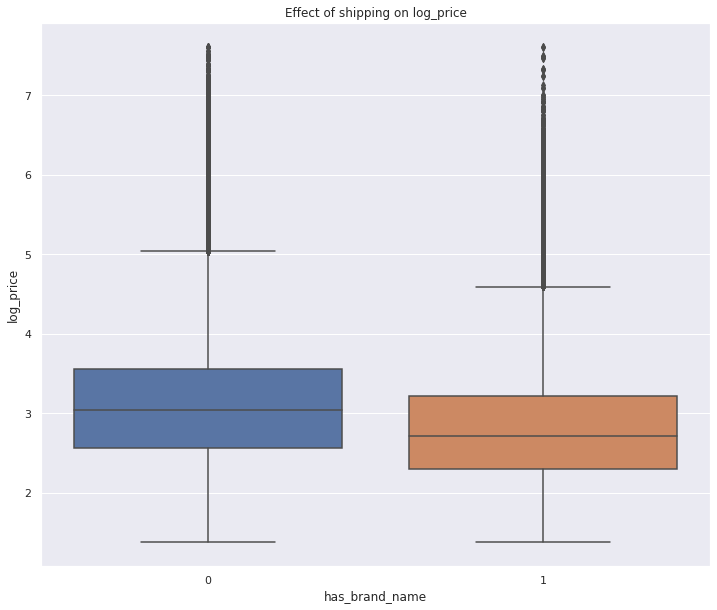

In [29]:
plt.figure(figsize=(12, 10))
sns.boxplot(x='has_brand_name', y='log_price', data=df)
plt.title('Effect of shipping on log_price')
plt.show()

- Median price of products with missing brand names is lower than products having brand name

### Expensive Brands

In [127]:
data = df.where(df['price'] > 100).sort_values(by=['price'], ascending=False)

brands = data.groupby('brand_name')['price'].agg(['count', 'mean']).sort_values(by=['count'], ascending=False).reset_index()

expensive_brands = brands[:20]

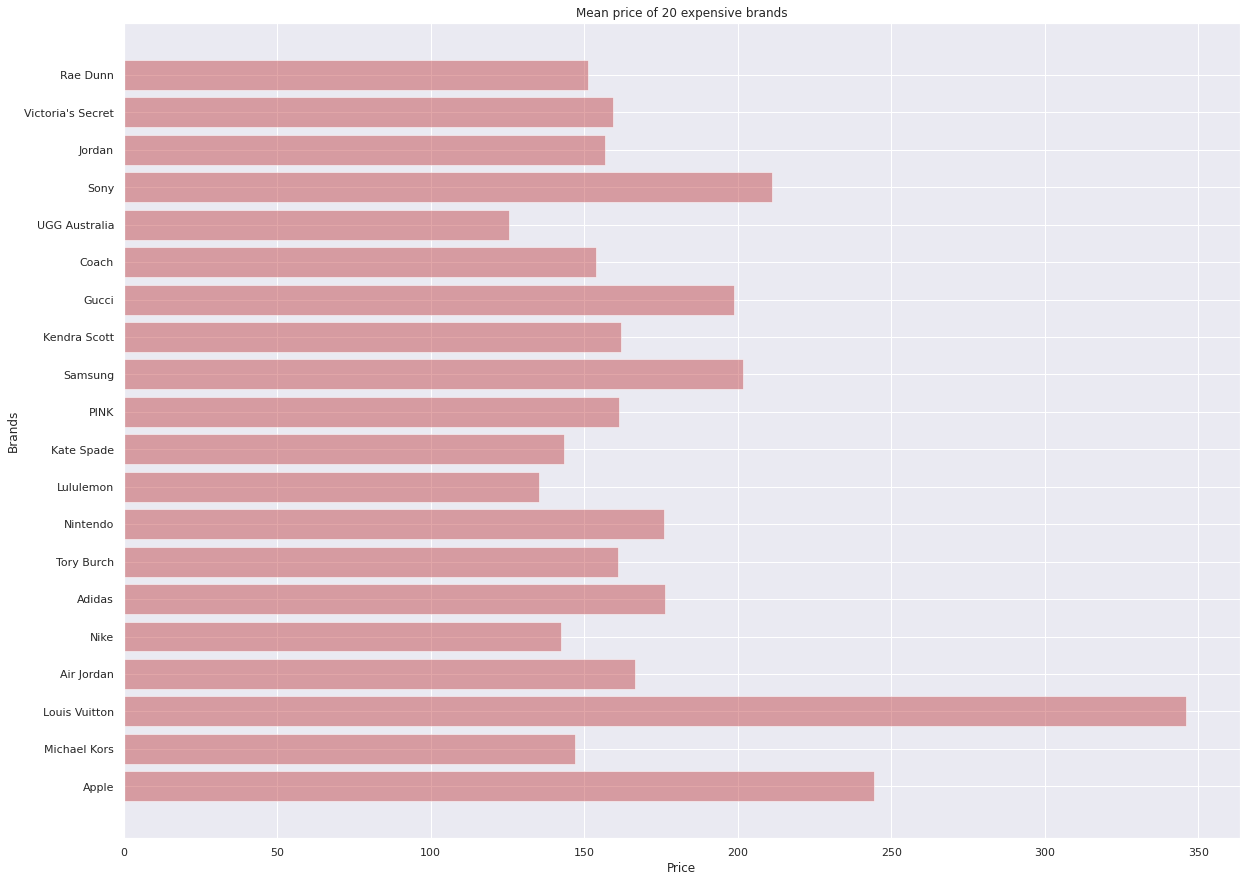

In [128]:
plt.figure(figsize=(20, 15))

plt.barh(range(0,len(expensive_brands)), expensive_brands['mean'], align='center', alpha=0.5, color='r')

plt.yticks(range(0,len(expensive_brands)), expensive_brands['brand_name'])
plt.xticks()
plt.title('Mean price of 20 expensive brands')
plt.xlabel('Price')
plt.ylabel('Brands')
plt.show()

- These brands have products which are expensive (or over $100)

### Luxurious Brands

In [129]:
data = df.where(df['price'] > 1000).sort_values(by=['price'], ascending=False)

brands = data.groupby('brand_name')['price'].agg(['count', 'mean']).sort_values(by=['count'], ascending=False).reset_index()

luxurious_brands = brands[:20]

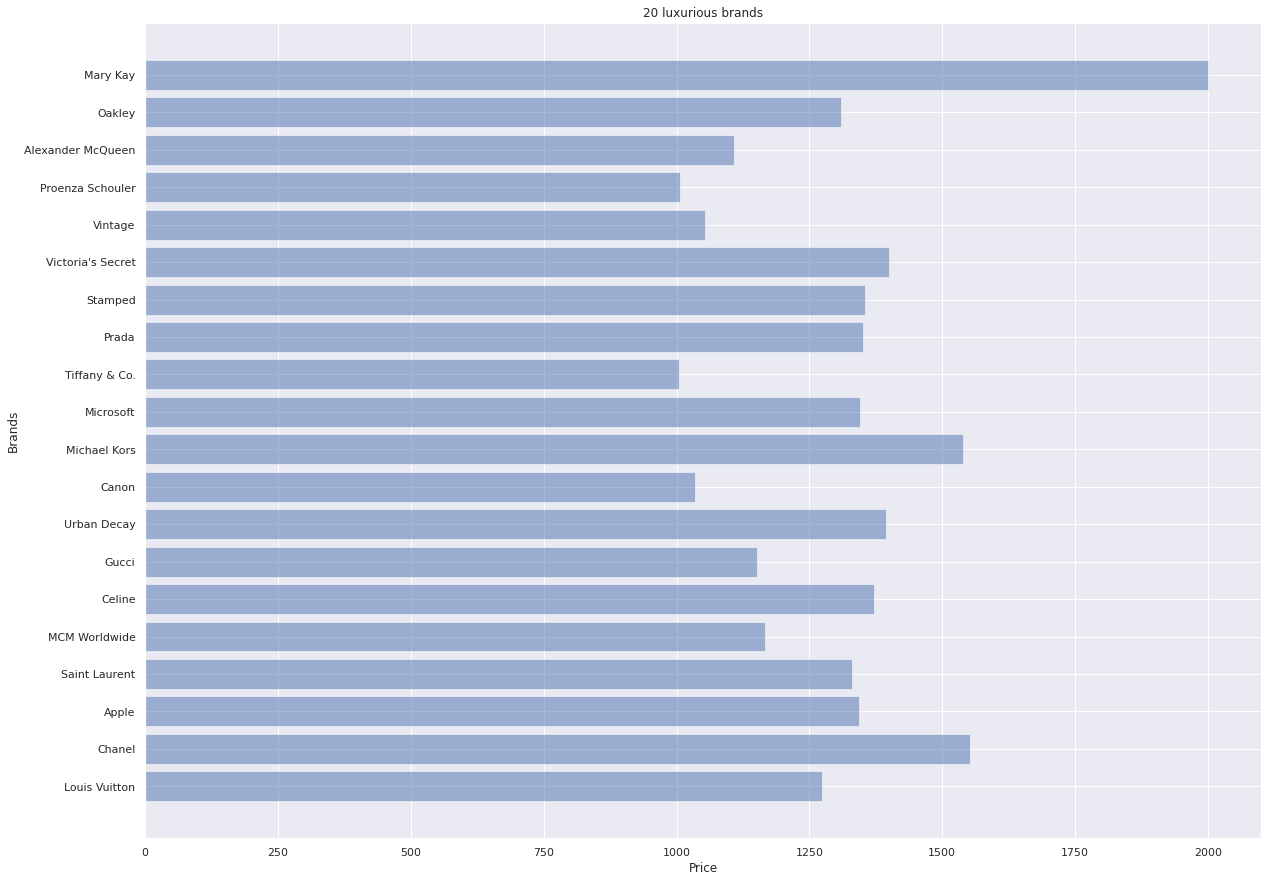

In [130]:
plt.figure(figsize=(20, 15))

plt.barh(range(0,len(luxurious_brands)), luxurious_brands['mean'], align='center', alpha=0.5, color='b')

plt.yticks(range(0,len(luxurious_brands)), luxurious_brands['brand_name'])
plt.xticks()
plt.title('20 luxurious brands')
plt.xlabel('Price')
plt.ylabel('Brands')
plt.show()

- These brands have products which are luxurious (or over $1000)

### Cheap Brands

In [131]:
data = df.where(df['price'] < 50).sort_values(by=['price'], ascending=False)

brands = data.groupby('brand_name')['price'].agg(['count', 'mean']).sort_values(by=['count'], ascending=False).reset_index()

cheap_brands = brands[:10]

In [132]:
cheap_brands

brand_name  count       mean
0               PINK  49441  21.320190
1               Nike  45201  21.777859
2  Victoria's Secret  45100  19.754091
3            LuLaRoe  26512  27.682125
4         FOREVER 21  15140  12.790885
5     American Eagle  13142  15.565858
6           Nintendo  12464  19.904565
7              Apple  11596  16.732149
8            Sephora  11427  17.870263
9  Bath & Body Works  10035  16.023019

- We have derived expensive, luxurious and cheap brands. But these brands can have products under $100 but they also have products which are expensive or luxurious
- There are 4809 unique brands in the training set
- Pink and Nike are the brands those have the most products
- There are 632682 products that do not have brand name present 
- Amongst the top selling 10 brands on mercari, it seems that products of these brands are not expensive. Whereas products of brands like Celine, Vitamix are expensive.

### Product Category

In [133]:
df.category_name.isna().sum()

0

In [134]:
df.category_name.describe()

count                                            1481658
unique                                              1288
top       Women/Athletic Apparel/Pants, Tights, Leggings
freq                                               60152
Name: category_name, dtype: object

In [135]:
df.category_name.value_counts()[0:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 60152
Women/Tops & Blouses/T-Shirts                                  46349
Beauty/Makeup/Face                                             34320
Beauty/Makeup/Lips                                             29901
Electronics/Video Games & Consoles/Games                       26547
Beauty/Makeup/Eyes                                             25200
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24668
Women/Underwear/Bras                                           21254
Women/Tops & Blouses/Tank, Cami                                20270
Women/Tops & Blouses/Blouse                                    20269
Name: category_name, dtype: int64

- There are 2 sub-categories under the category_name

In [136]:
#splitting category_name into category_0, category_1 and category_2
df = process_category(df)

In [137]:
print('There are {} unique values in category_0'.format(len(df['category_0'].unique())))
print('There are {} unique values in category_1'.format(len(df['category_1'].unique())))
print('There are {} unique values in category_2'.format(len(df['category_2'].unique())))

There are 10 unique values in category_0
There are 114 unique values in category_1
There are 871 unique values in category_2


### Main Category

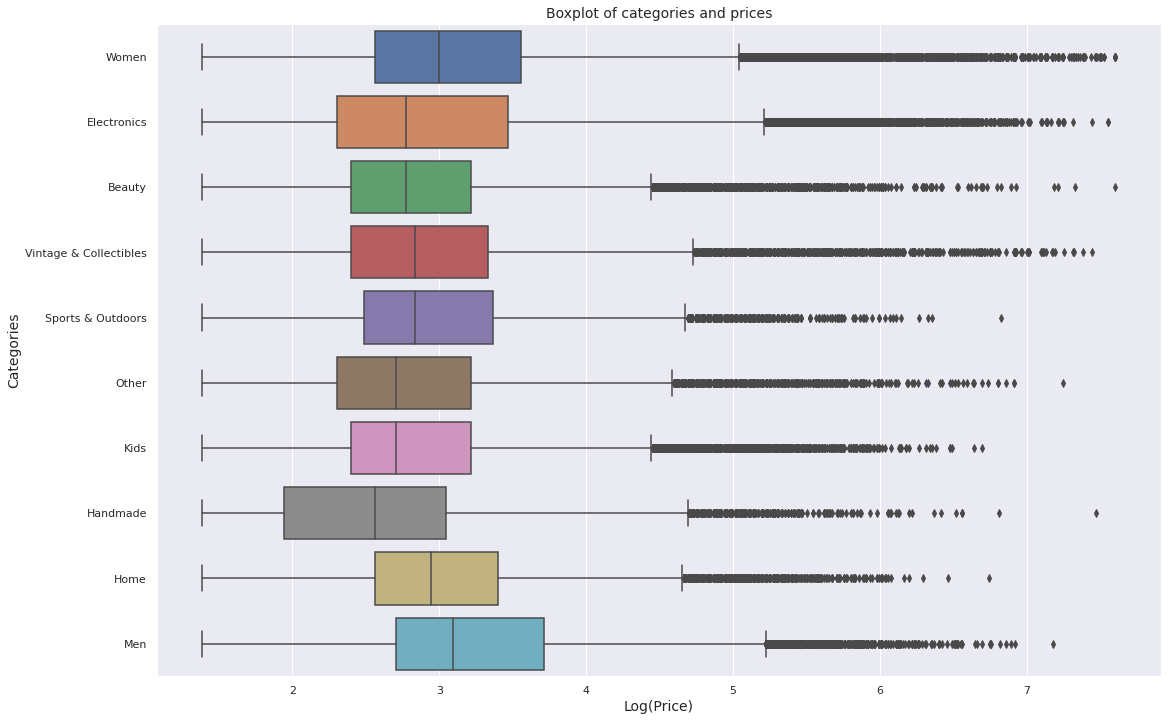

In [139]:
plt.figure(figsize=(18,12))
sns.boxplot(x = 'log_price', y = 'category_0', data = df, orient = 'h')
plt.title('Boxplot of categories and prices', fontsize=14)
plt.xlabel('Log(Price)', fontsize=14)
plt.ylabel('Categories', fontsize=14)
plt.show()

- There is a price difference between products of main categories
- Prices of products from Handmade category are generally less than other categories
- Categories such as Men/Women have higher median prices because of some expensive brands

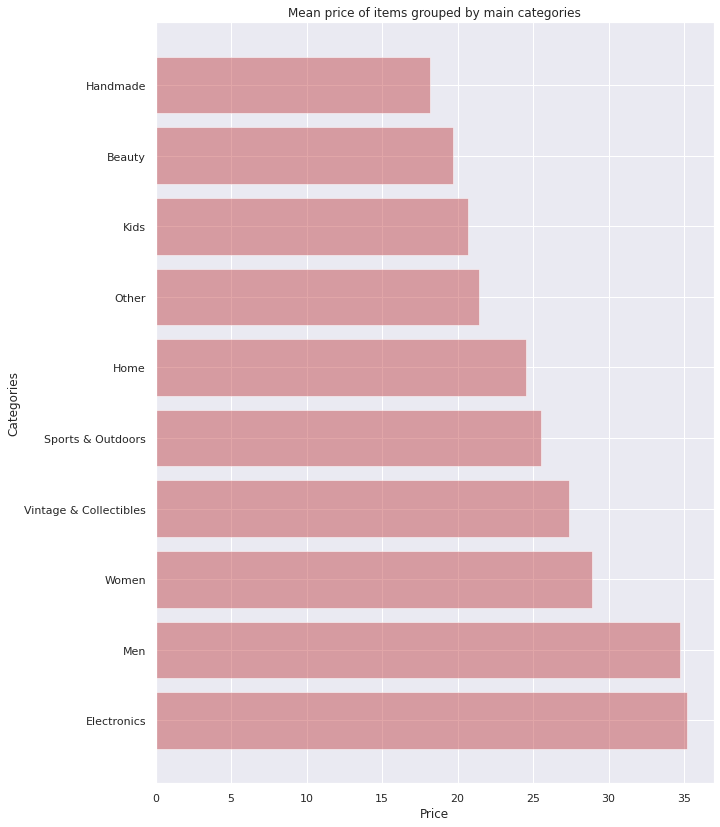

In [141]:
mean = df.groupby('category_0')['price'].agg(['mean']).sort_values(by=['mean'], ascending = False).reset_index()

plt.figure(figsize=(10, 14))
plt.barh(range(0,len(mean)), mean['mean'], align='center', alpha=0.5, color='r')

plt.yticks(range(0,len(mean)), mean['category_0'])
plt.xticks()
plt.title('Mean price of items grouped by main categories')
plt.xlabel('Price')
plt.ylabel('Categories')
plt.show()

- Products in categories Men and Electronics have highest mean price
- Handmade category products have the lowest mean price

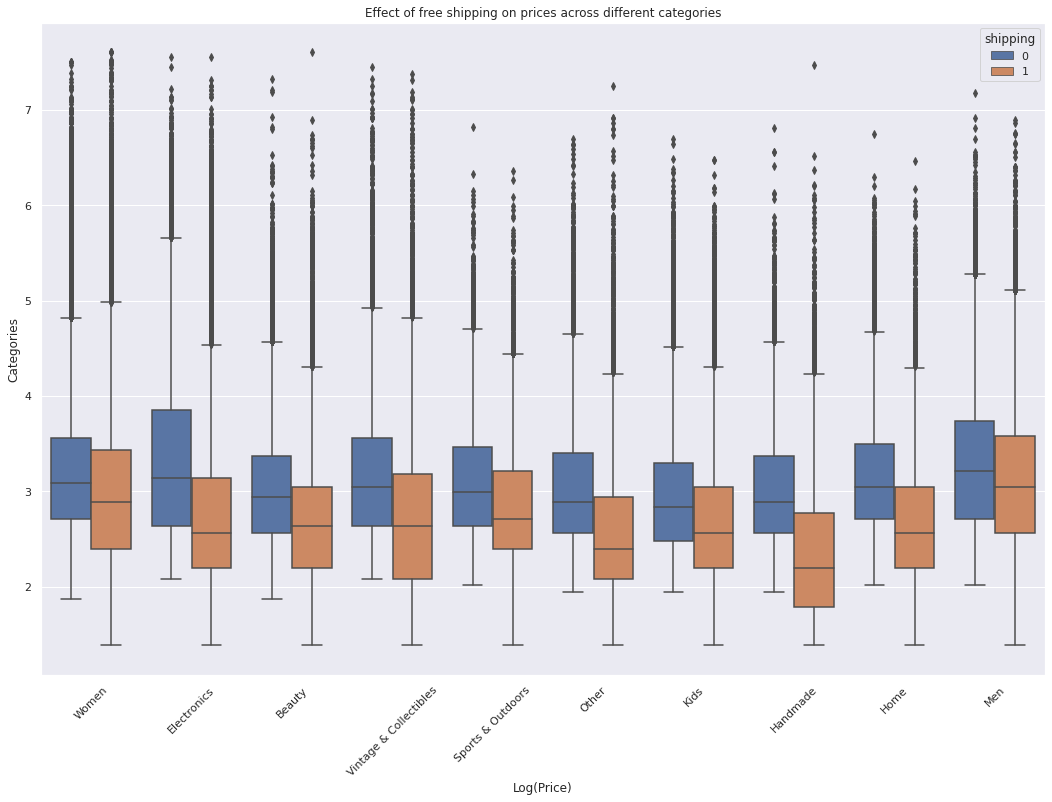

In [142]:
plt.figure(figsize=(18, 12))
chart = sns.boxplot(x = 'category_0', y = 'log_price', hue = 'shipping', data = df)
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)
plt.title('Effect of free shipping on prices across different categories')
plt.xlabel('Log(Price)')
plt.ylabel('Categories')
plt.show()

- If we see in terms of shipping, shipping fee paid by buyer is always higher than seller no matter the categories. Infact for handmade product there is a lot of difference

### First Subcategory

In [143]:
cat_mean = df.groupby('category_1')['price'].agg(['mean']).sort_values(by=['mean'], ascending = False).reset_index()[:20]

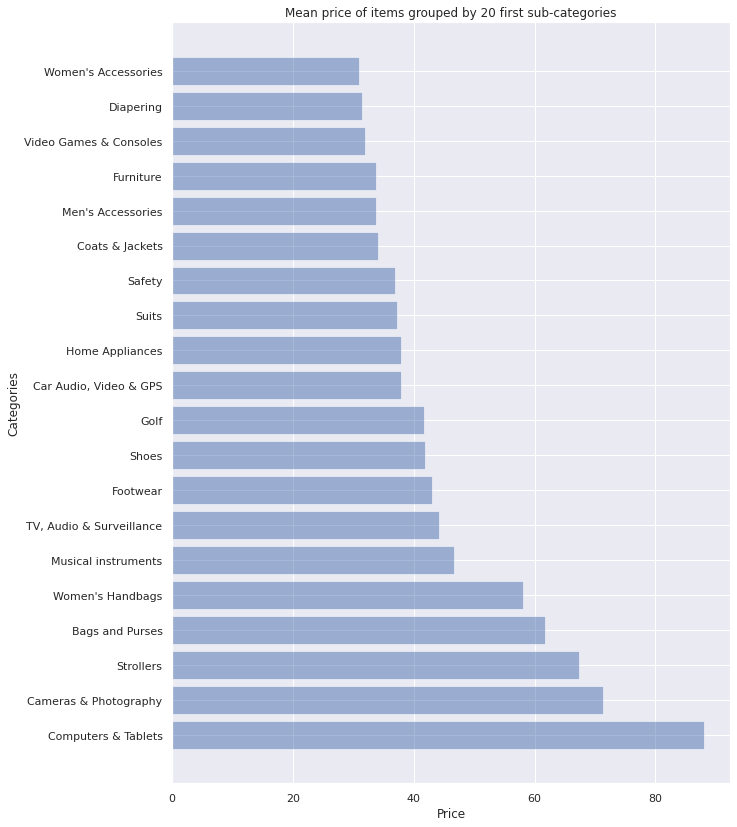

In [145]:
plt.figure(figsize=(10, 14))

plt.barh(range(0,len(cat_mean)), cat_mean['mean'], align='center', alpha=0.5, color='b')

plt.yticks(range(0,len(cat_mean)), cat_mean['category_1'])
plt.xticks()
plt.title('Mean price of items grouped by 20 first sub-categories')
plt.xlabel('Price')
plt.ylabel('Categories')
plt.show()

### Second Subcategory

In [146]:
sub_cat_mean = df.groupby('category_2')['price'].agg(['mean']).sort_values(by=['mean'], ascending = False).reset_index()[:20]

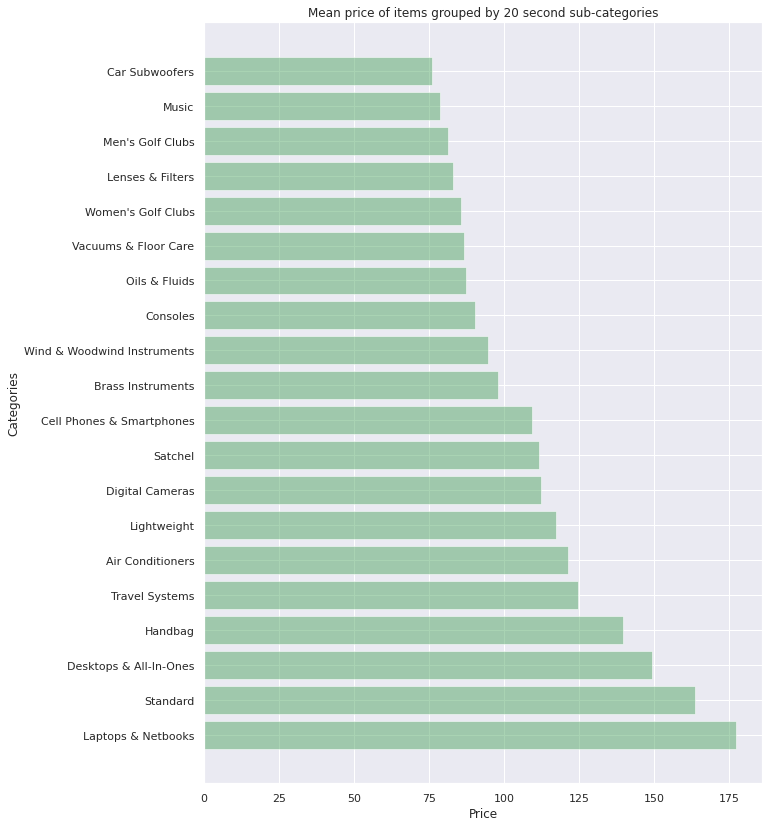

In [147]:
plt.figure(figsize=(10, 14))

plt.barh(range(0,len(sub_cat_mean)), sub_cat_mean['mean'], align='center', alpha=0.5, color='g')

plt.yticks(range(0,len(sub_cat_mean)), sub_cat_mean['category_2'])
plt.xticks()
plt.title('Mean price of items grouped by 20 second sub-categories')
plt.xlabel('Price')
plt.ylabel('Categories')
plt.show()

- Women/Athletic Apparel/Pants, Tights, Leggings has the highest number of products on the marketplace. 
- There are 1287 unique categories. 
- There are 6327 missing values. 
- We need to clean data in category_name feature. We will remove the special characters. Also items with slashes are nested categories. We will create 3 columns for category and its sub-categories.

### Item Condition

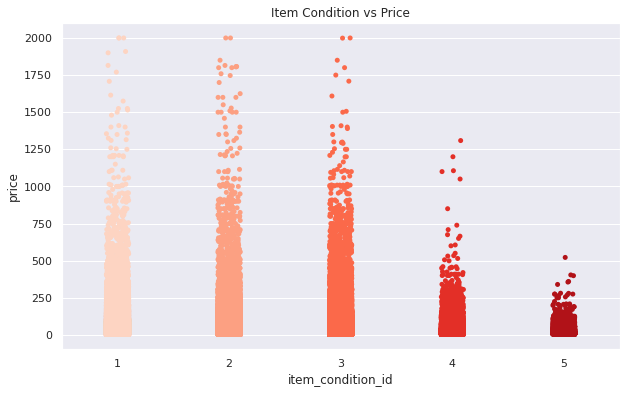

In [148]:
plt.figure(figsize=(10, 6))
sns.stripplot(df['item_condition_id'], df['price'], palette = 'Reds')
plt.title("Item Condition vs Price")
plt.show()

In [149]:
df['item_condition_id'].value_counts(normalize = True) * 100

1    43.211321
3    29.149237
2    25.322645
4     2.156031
5     0.160766
Name: item_condition_id, dtype: float64

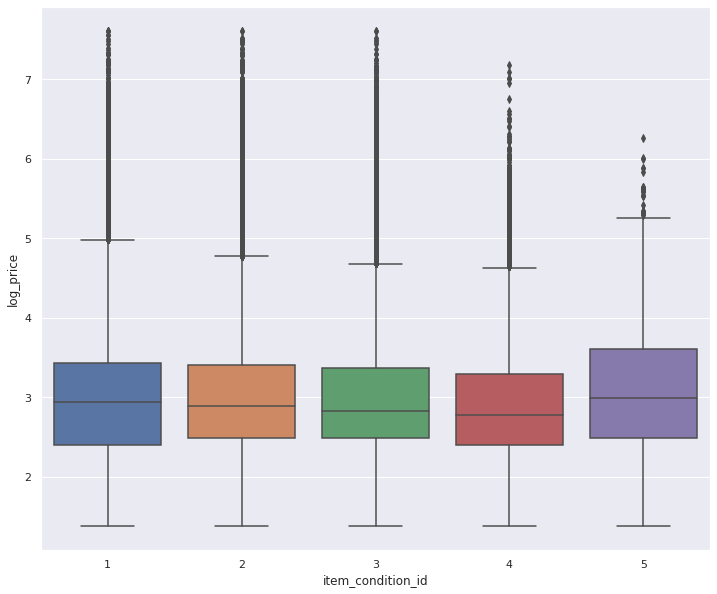

In [157]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(x='item_condition_id', y='log_price', data=df)
plt.show()

In [158]:
df.groupby('item_condition_id')['price'].describe()

count       mean        std  min   25%   50%    75%  \
item_condition_id                                                           
1                  640244.0  26.493313  35.248302  3.0  10.0  18.0  30.00   
2                  375195.0  27.578747  42.011105  3.0  11.0  17.0  29.00   
3                  431892.0  26.557241  40.037663  3.0  11.0  16.0  28.00   
4                   31945.0  24.362169  35.684218  3.0  10.0  15.0  26.00   
5                    2382.0  31.730479  39.536983  3.0  11.0  19.0  35.75   

                      max  
item_condition_id          
1                  2000.0  
2                  2000.0  
3                  2000.0  
4                  1309.0  
5                   522.0

- As per assumption, most sellers tend to give item_condition_id as 1 as buyers don't buy products which are not in great condition
- Also products which are rated as 5 are also priced similar to those with 1
- 43% products are marked as with item condition of 1 and only 0.1% are marked as 5
- Median price of products with item_condition_id of 5 (or poor) is greater than the items with good condition
- This is a Ordinal categorical variable as it has natural ordering to it on the scale of 1 to 5

## Text Analysis

### Product Name

In [152]:
print(df.name.values[10])
print('-'*50)
print(df.name.values[50])
print('-'*50)
print(df.name.values[500])
print('-'*50)
print(df.name.values[1000])
print('-'*50)
print(df.name.values[10000])

Nose stud 1
--------------------------------------------------
Origami Owl Charm: Pink Nail Polish
--------------------------------------------------
9 cards PATRIOTS NFL
--------------------------------------------------
Lavender Bouquet
--------------------------------------------------
Free ship 3 random belly rings


In [153]:
print('Unique product names in the dataset are {:.2f}%'.format(df['name'].str.lower().str.strip().nunique() / df.shape[0] * 100))

Unique product names in the dataset are 76.85%


(-0.5, 2999.5, 1999.5, -0.5)

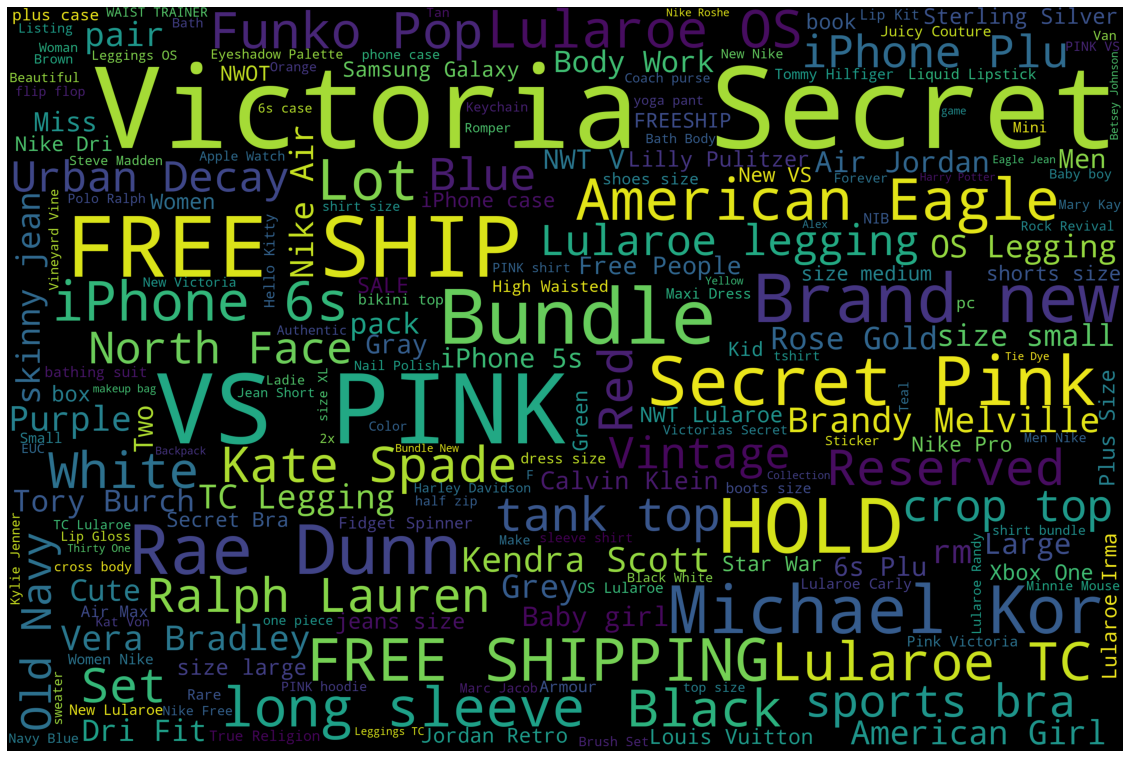

In [39]:
from wordcloud import WordCloud

cloud = WordCloud(width=3000, height=2000).generate(' '.join(df.name.astype(str)))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

Top words seems to be brand names such as Victoria Secret, American Eagle, Michael Kors which are brand names as people tends to keep them in the product title. Same can be done with product description.

In [40]:
df['len_name'] = df['name'].apply(lambda x: len(x))

df.groupby('len_name')['price'].agg(['mean', 'median'])[0:10]

mean  median
len_name                   
1         29.647059    24.0
2         37.380711    21.0
3         32.206240    16.0
4         25.282387    18.0
5         24.527663    15.0
6         27.967502    18.0
7         25.670857    16.0
8         27.921668    16.0
9         29.108814    16.0
10        25.576462    15.0

- This means product name with more length have greater average price

### Brand Names in Product Name

In [104]:
brands = df['brand_name'].unique().tolist()
name = df['name'].tolist()
name_list = [i.strip(',').split(' ') for i in name]
name_corpus = [item for name in name_list for item in name]

In [111]:
brands = set(brands)
brands_in_name = list(brands.intersection(name_corpus))

(-0.5, 2999.5, 1999.5, -0.5)

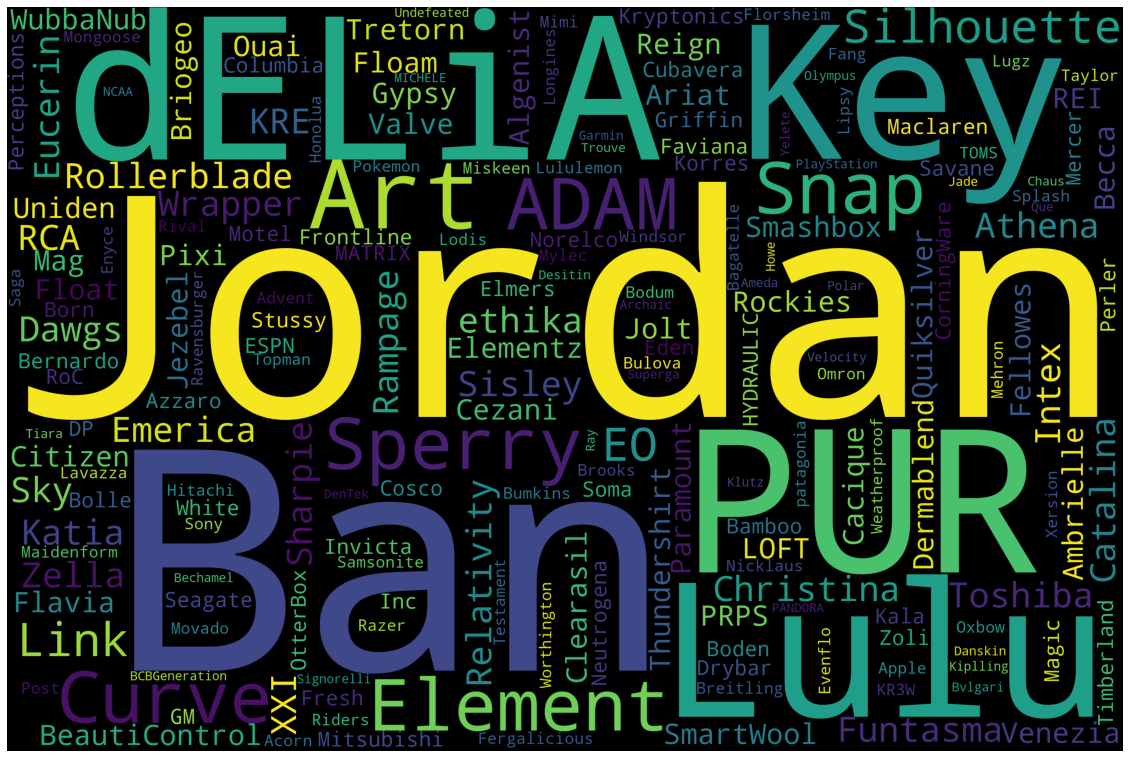

In [114]:
cloud = WordCloud(width=3000, height=2000).generate(' '.join(brands_in_name))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

In [14]:
#The temp object here is a pandas.series object which does not have a iplot method when not linked to plotly. 
#We need cufflinks to link plotly to pandas and add the iplot method.

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [15]:
def get_words(corpus, n = 20):
    vect = CountVectorizer().fit(corpus)
    bow = vect.transform(corpus)
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [16]:
def get_bigrams(corpus, n = 20):
    vect = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bow = vect.transform(corpus)
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [23]:
common_words = get_words(data['name'], 10)

df_words = pd.DataFrame(common_words, columns = ['name' , 'count'])

df_words.groupby('name').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    title='Top 10 words in product name after preprocessing data')

In [24]:
common_words = get_bigrams(data['name'], 10)

df_words = pd.DataFrame(common_words, columns = ['name' , 'count'])

df_words.groupby('name').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    title='Top 10 bi-grams in product name after preprocessing data')

Most of the occured bi-grams are the brand names - victoria secret, rae dunn, michael kors, etc.

### Product Description

In [155]:
print(df.item_description.values[101])
print('-'*50)
print(df.item_description.values[60])
print('-'*50)
print(df.item_description.values[590])
print('-'*50)
print(df.item_description.values[1020])
print('-'*50)
print(df.item_description.values[10800])

✨brandy melville stickers free shipping✨ ✅authentic brandy melville stickers ✅all perfect condition with no scratches or tears ✨will be mailed in an envelope with a stamp✨ ✅hand picked by me ✅great variety ❤️pricing❤️ 7 for [rm] 9 for [rm] 11 for [rm] 15 for [rm] ☄️please comment if you would like something other than the 7 for [rm] so I can create a separate listing for you☄️ ❤️if you would like to hand-pick it will be [rm] extra❤️ ✨comment for a closer look or more information✨ ✨ask about bundles for discounts!✨
--------------------------------------------------
Brand new⭐️
--------------------------------------------------
No description yet
--------------------------------------------------
Ask questions
--------------------------------------------------
Brand new! Originally from target


(-0.5, 2999.5, 1999.5, -0.5)

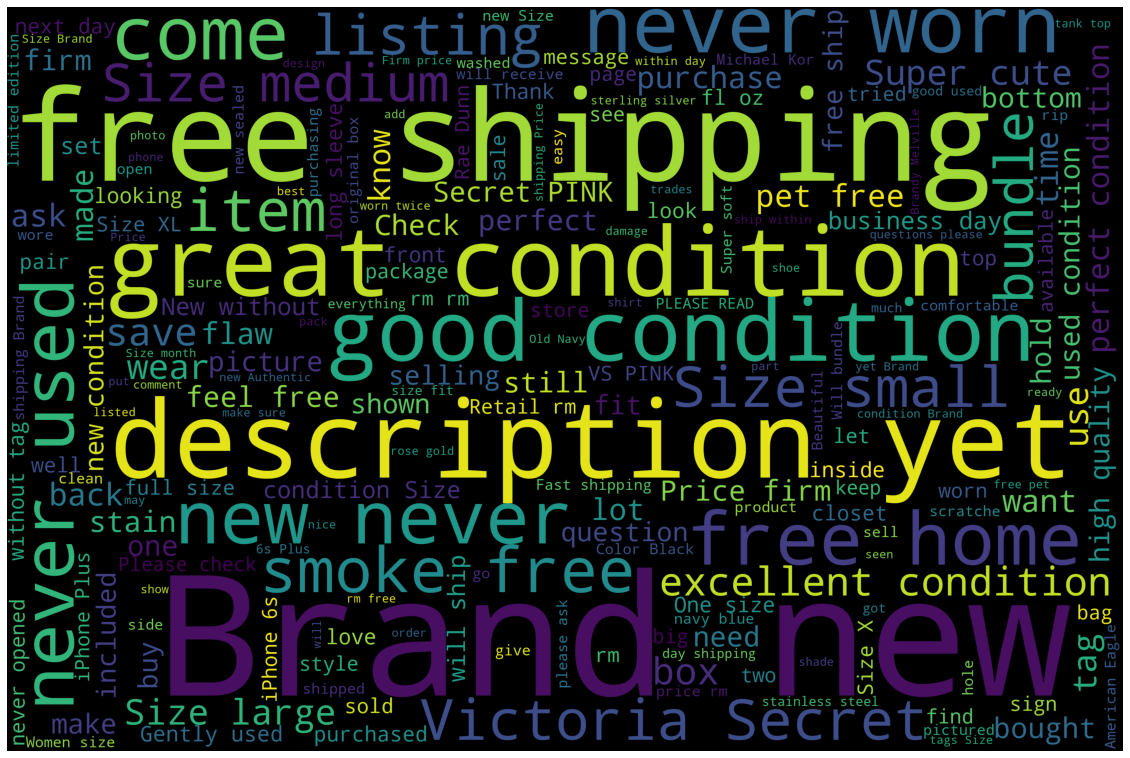

In [45]:
cloud = WordCloud(width=3000, height=2000).generate(' '.join(df.item_description.astype(str)))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

### Brand Names in Item Description

In [161]:
df = handle_missing_values(df)

In [162]:
brands = df['brand_name'].unique().tolist()
name = df['item_description'].tolist()
name_list = [i.strip(',').split(' ') for i in name]
name_corpus = [item for name in name_list for item in name]

In [163]:
brands = set(brands)
brands_in_name = list(brands.intersection(name_corpus))

(-0.5, 2999.5, 1999.5, -0.5)

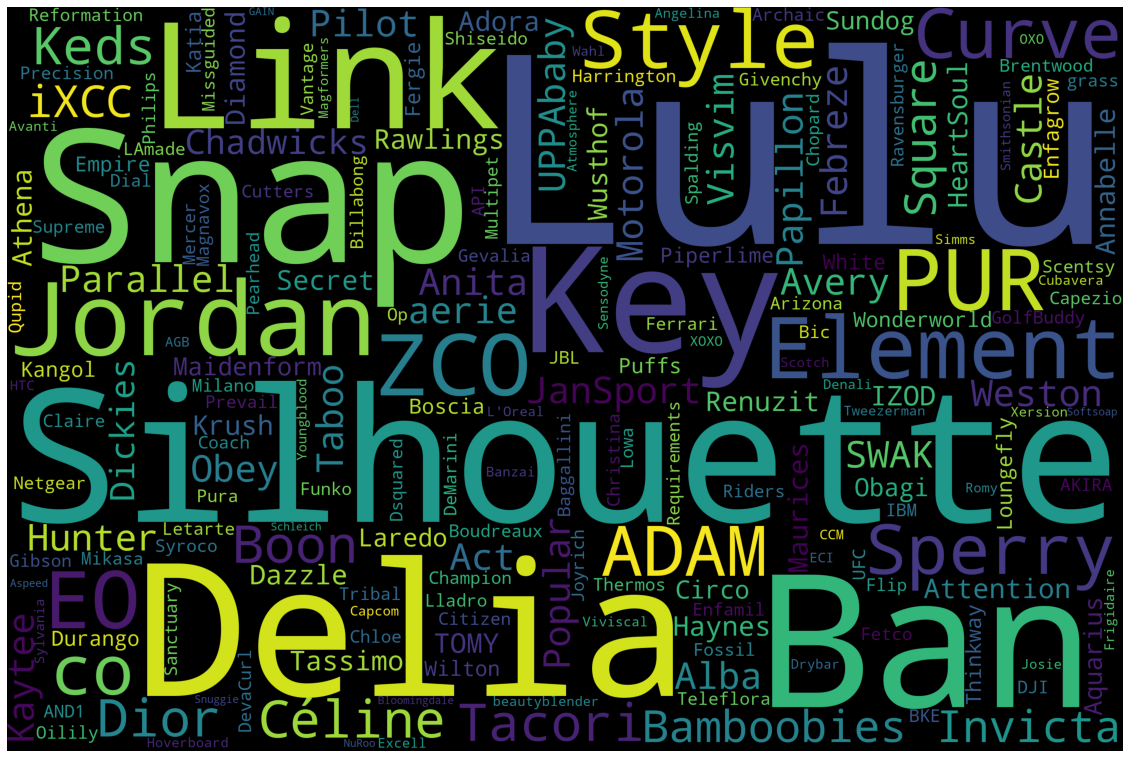

In [164]:
cloud = WordCloud(width=3000, height=2000).generate(' '.join(brands_in_name))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

In [25]:
common_words = get_words(data['item_description'], 10)

df_words = pd.DataFrame(common_words, columns = ['text' , 'count'])

df_words.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    title='Top 10 words in product description after preprocessing data')

In [26]:
common_words = get_bigrams(data['item_description'], 10)

df_words = pd.DataFrame(common_words, columns = ['text' , 'count'])

df_words.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    title='Top 10 bi-grams in product description after preprocessing data')

## Preprocessing Data

In [165]:
#stopwords without no, not, etc
STOPWORDS = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [166]:
def handle_missing_values(input_data):
    """
    Fills the nan/missing values with 'missing' for text columns
    """
    input_data.fillna({'name': 'missing', 'item_description': 'missing'}, inplace=True)
    
    return input_data

In [167]:
# https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(sentence):
    """
    Remove emojis from the string
    """
    pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return pattern.sub(r'', sentence)

In [168]:
def remove_punctuation(sentence):
    """
    Remove all puntuations from the string
    """
    import string
    regular_punct = list(string.punctuation)
    
    for punc in regular_punct:
        if punc in sentence:
            sentence = sentence.replace(punc, ' ')

    return sentence.strip()

In [169]:
# https://www.appliedaicourse.com/
def decontracted(phrase):
    """
    Expand and create common english contractions in the text
    """
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [170]:
# https://www.appliedaicourse.com/
def process_text(input_data, cols):
    """
    Take the text columns and process the data. Expand contractions, use regex to remove symbols/numbers, remove emojis, punctuations
    and stopwords and convert text to lowercase
    """
    for col in cols:
        
        processed_data = []
        
        for sent in input_data[col].values:
            
            sent = decontracted(sent)
            sent = sent.replace('\\r', ' ')
            sent = sent.replace('\\"', ' ')
            sent = sent.replace('\\n', ' ')
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
            sent = remove_emoji(sent)
            sent = remove_punctuation(sent)
            sent = ' '.join(e for e in sent.split() if e not in STOPWORDS)
            processed_data.append(sent.lower().strip())
            
        input_data[col] = processed_data
        
    return input_data

In [171]:
def process_category(input_data):
    """
    Split the category_name into 3 parts as category_0, category_1 and category_2
    """
    for i in range(3):
        
        def get_categories(ele):
            
            if type(ele) != str:
                return np.nan
        
            cat = ele.split('/')
            
            if i >= len(cat):
                return np.nan
            else:
                return cat[i]

        col_name = 'category_' + str(i)
        
        input_data[col_name] = input_data['category_name'].apply(get_categories)
        
        input_data.fillna({'category_name': 'Other'}, inplace = True)
    
    return input_data

In [182]:
#nlp features
def get_text_features(input_data):
    """
    NLP features derived from the text columns
    """
    input_data['has_brand_name'] = (input_data['brand_name'].isnull()).astype(np.int8) #if brand_name is present, 1 else 0
    
    input_data['has_price'] = np.where(input_data['item_description'].str.contains(' rm ', na = False), 1, 0) #if item_description has [rm] which is price string removed, 1 else 0

    input_data['reversed_item_condition_id'] = 5 - input_data['item_condition_id']

    input_data['is_luxurious'] = (input_data['brand_name'].isin(luxurious_brands['brand_name'])).astype(np.int8)

    input_data['is_expensive'] = (input_data['brand_name'].isin(expensive_brands['brand_name'])).astype(np.int8)

    input_data['is_cheap'] = (input_data['brand_name'].isin(cheap_brands['brand_name'])).astype(np.int8)

    input_data['len_name'] = input_data['name'].str.len()
    input_data['len_item_description'] = input_data['item_description'].str.len()
    input_data['len'] = input_data['len_name'] + input_data['len_item_description']

    input_data['token_count_name'] = input_data['name'].apply(lambda x: len(x.split(' ')))
    input_data['token_count_item_description'] = input_data['item_description'].apply(lambda x: len(x.split(' ')))
    input_data['token_count'] = input_data['token_count_name'] + input_data['token_count_item_description']
    input_data['token_count_ratio'] = input_data['token_count_name']/input_data['token_count_item_description']

    input_data["name_words"] = input_data["name"].str.count("(\s|^)[a-z]+(\s|$)")
    input_data["item_description_words"] = input_data["item_description"].str.count("(\s|^)[a-z]+(\s|$)")
    input_data["words"] = input_data["name_words"] + input_data["item_description_words"]

    input_data["name_numbers"] = input_data["name"].str.count("(\s|^)[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?(\s|$)")
    input_data["item_description_numbers"] = input_data["item_description"].str.count("(\s|^)[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?(\s|$)")
    input_data["numbers"] = input_data["name_numbers"] + input_data["item_description_numbers"]

    input_data["name_letters"] = input_data["name"].str.count("[a-zA-Z]")
    input_data["item_description_letters"] = input_data["item_description"].str.count("[a-zA-Z]")
    input_data["letters"] = input_data["name_letters"] + input_data["item_description_letters"]

    input_data["name_digits"] = input_data["name"].str.count("[0-9]")
    input_data["item_description_digits"] = input_data["item_description"].str.count("[0-9]")
    input_data["digits"] = input_data["name_digits"] + input_data["item_description_digits"]

    return input_data

In [183]:
def preprocess(input_data):
    """
    Process the data by handling missing values, process category_name, process text
    """
    input_data = input_data[(input_data['price'] >= 3) & (input_data['price'] <= 2000)]
    
    input_data['price'] = np.log1p(input_data['price'])

    input_data = handle_missing_values(input_data)
    
    input_data = process_category(input_data)
    
    input_data = process_text(input_data, ['name', 'item_description', 'category_name'])

    return input_data

In [184]:
data = preprocess(df)

data.fillna({'category_0': 'other', 'category_1': 'other', 'category_2': 'other'}, inplace = True)

In [185]:
#NLP features
data = get_text_features(data)

data.fillna({'brand_name': ' '}, inplace = True)

#concatenate text features
data['name'] = data['name'] + ' ' + data['brand_name'] + ' ' + data['category_name']
data['text'] = data['name'] + ' ' + data['item_description']

data = data.drop(columns = ['brand_name', 'item_description', 'category_name'], axis = 1)

## Correlation matrices

In [186]:
df1 = data[['price', 'item_condition_id',
       'shipping', 'category_0', 'category_1',
       'category_2', 'has_brand_name', 'has_price',
       'reversed_item_condition_id', 'is_luxurious', 
        'is_expensive']]

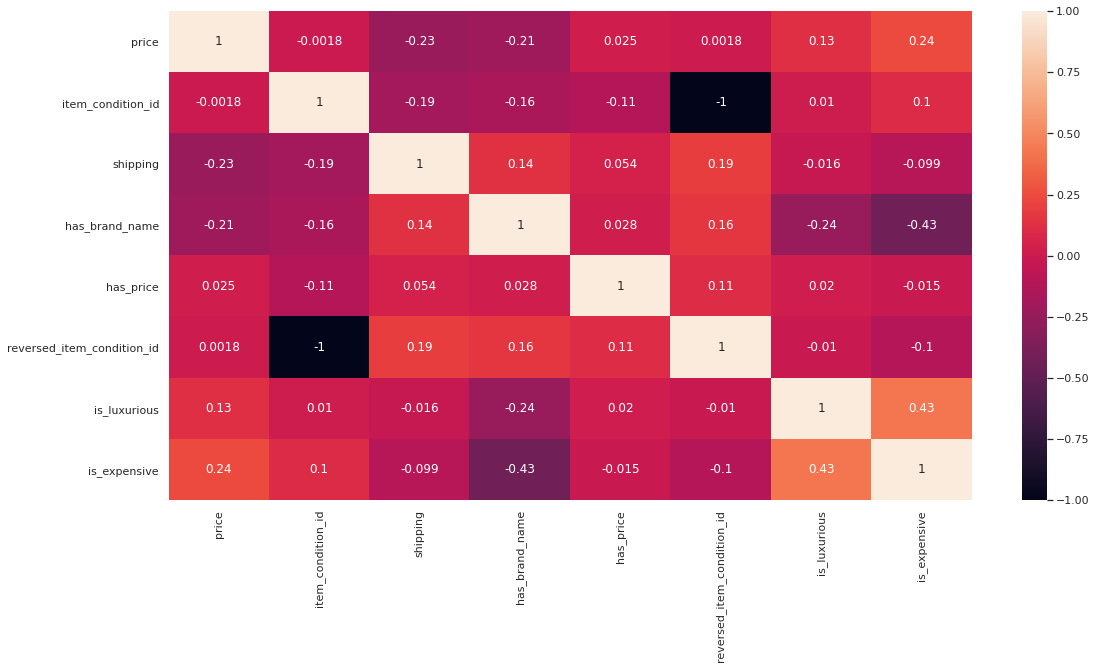

In [187]:
corrMatrix  = df1.corr()
plt.figure(figsize = (18,9))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [188]:
df2 = data[['price', 'is_cheap', 'len_name', 'len_item_description', 'len',
       'token_count_name', 'token_count_item_description', 'token_count',
       'token_count_ratio', 'name_words', 'item_description_words', 'words',
       'name_numbers', 'item_description_numbers', 'numbers', 'name_letters']]

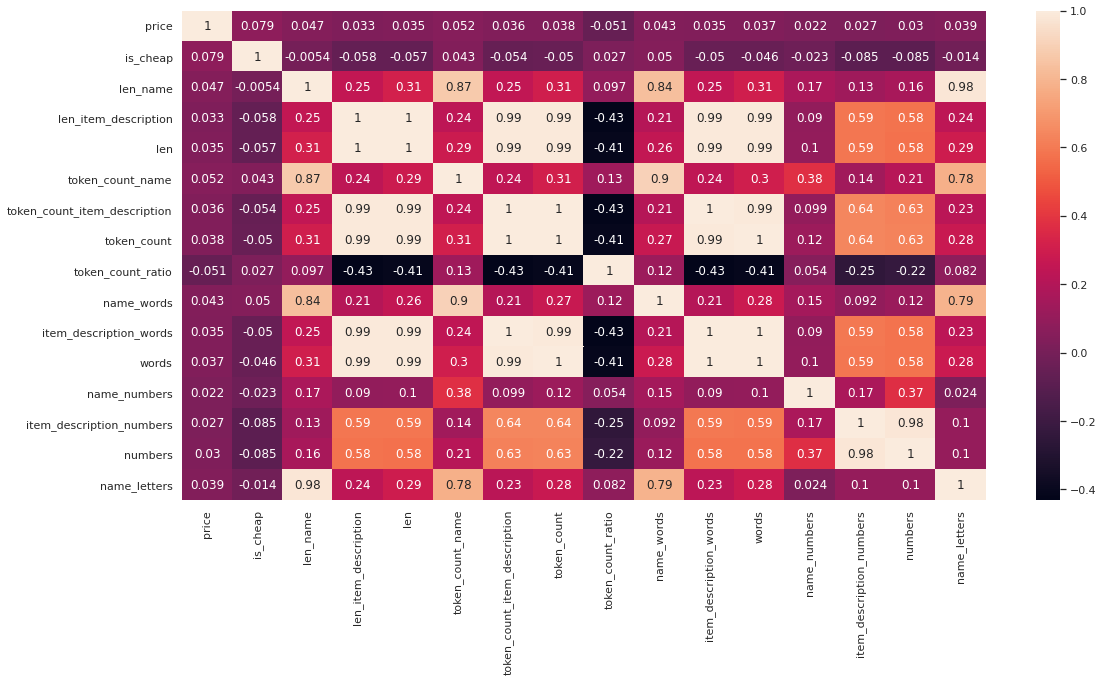

In [189]:
corrMatrix  = df2.corr()
plt.figure(figsize = (18,9))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [190]:
df3 = data[['price', 'item_description_letters', 'letters', 'name_digits',
       'item_description_digits', 'digits']]

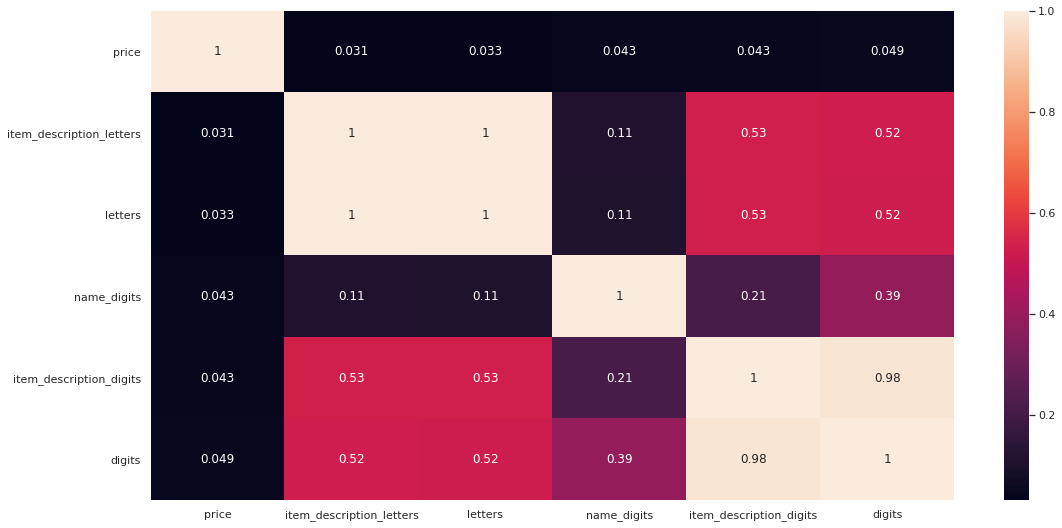

In [191]:
corrMatrix  = df3.corr()
plt.figure(figsize = (18,9))
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Conclusions/Observations from EDA + FE

### EDA

- 42.67% of brand names are missing from the data with 4809 unique brands
- Pink and Nike are the brands those have the most products
- Most of the item descriptions are missing or filled with 'No desription yet'
- There are 49 products which are repeated in the dataset
- Target variable 'Price' is positively skewed but log(price) is normally distributed
- Women/Athletic Apparel/Pants, Tights, Leggings has the highest number of products on the marketplace
- Items with item_condition_id as 5 are priced lower as expected
- Top words in item title viz.name are brand names such as Victoria Secret, American Eagle, Michael Kors which are brand names as people tend to keep them in the product title to get views

### FE

- We derived many NLP features such as token number, ratio of tokens, etc which tend to not work
- is_expensive, is_luxurious seems to have high predictive power
- For is_expensive, we took the brands which were having high average priced products
- For is_luxurious, we took the highest priced products in the dataset
- Other NLP features seems to be uncorrelated

## Modelling

In [192]:
"""
Taking necessary features for modeling
"""
data = data[['price', 'name', 'category_0', 'category_1',
       'category_2', 'shipping', 'item_condition_id', 'is_expensive', 'is_luxurious', 'text']]

In [48]:
"""
Split the dataset into train and test
"""
y = data['price']

X = data.drop('price', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [58]:
print('--Train and Test--')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

--Train and Test--
(1185326, 9) (1185326,)
(296332, 9) (296332,)


In [68]:
#one hot encoding of category names
def get_ohe(X_train, X_test, col_name):
    """
    Get one hot encoded features
    """
    vect = CountVectorizer()
    tr_ohe = vect.fit_transform(X_train[col_name].values)
    te_ohe = vect.transform(X_test[col_name].values)

    return tr_ohe, te_ohe

In [69]:
#tfidf word embeddings
def get_text_encodings(X_train, X_test, col_name, min_val, max_val):
    """
    Get TFIDF encodings with max_features capped at 1M
    """
    vect = TfidfVectorizer(min_df = 10, ngram_range = (min_val, max_val), max_features = 1000000)
    tr_text = vect.fit_transform(X_train[col_name].values)
    te_text = vect.transform(X_test[col_name].values)

    return tr_text, te_text

In [70]:
def generate_encodings(X_train, X_test):
    """
    Get encodings for all the features. Scale and normalize the numerical features. Stack the encoded features horizontally.
    """
    tr_ohe_category_0, te_ohe_category_0 = get_ohe(X_train, X_test, 'category_0')
    tr_ohe_category_1, te_ohe_category_1 = get_ohe(X_train, X_test, 'category_1')
    tr_ohe_category_2, te_ohe_category_2 = get_ohe(X_train, X_test, 'category_2')

    tr_trans = csr_matrix(pd.get_dummies(X_train[['shipping', 'item_condition_id', 'is_expensive', 'is_luxurious']], sparse=True).values)
    te_trans = csr_matrix(pd.get_dummies(X_test[['shipping', 'item_condition_id', 'is_expensive', 'is_luxurious']], sparse=True).values)

    tr_name, te_name = get_text_encodings(X_train, X_test, 'name', 1, 1)
    tr_text, te_text = get_text_encodings(X_train, X_test, 'text', 1, 2)

    train_data = hstack((tr_ohe_category_0, tr_ohe_category_1, tr_ohe_category_2, tr_trans, \
                       tr_name, tr_text)).tocsr().astype('float32')


    test_data = hstack((te_ohe_category_0, te_ohe_category_1, te_ohe_category_2, te_trans, \
                       te_name, te_text)).tocsr().astype('float32')

    return train_data, test_data

In [71]:
"""
Generate encoding of all the features and print the final data matrix that will be the input for the ML models
"""
train_data, test_data = generate_encodings(X_train, X_test)

print('--Final Data Matrix--')
print(train_data.shape, y_train.shape)
print(test_data.shape, y_test.shape)

--Final Data Matrix--
(1185326, 363097) (1185326,)
(296332, 363097) (296332,)


In [72]:
def get_rmsle(y_true, y_pred):
    """
    Get RMSLE score by passing actual values and the predictions from models
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Machine Learning

### XGBoost Regression

In [34]:
"""
XGBRegressor
"""
xgb_model = xgb.XGBRegressor()
xgb_model.fit(train_data, y_train)

predictions = xgb_model.predict(train_data)
train_score = get_rmsle(np.expm1(y_train), np.expm1(predictions))
print('Train rmsle explained: ', train_score)

predictions = xgb_model.predict(test_data)
test_score = get_rmsle(np.expm1(y_test), np.expm1(predictions))
print('Test rmsle explained: ', test_score)

Train rmsle explained:  0.5096650847471199
Test rmsle explained:  0.5156031747178028


### Hyperparamter tuning

In [35]:
#values of these parameters are taken randomly
xgb_params = {'gamma': 0.2, 'reg_lambda': 0.5, 'learning_rate': 0.07,
              'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.6,
              'max_depth': 6}

estimators = [50, 100, 300, 500, 1000]

for i in estimators:
    regr = xgb.XGBRegressor(n_estimators=i)
    regr.set_params(**xgb_params)

    regr.fit(train_data, y_train)
    y_pred = regr.predict(test_data)
    
    print('Test rmsle explained for n_estimators = {} is {:.3f}'.format(i, get_rmsle(np.expm1(y_test), np.expm1(y_pred))))

Test rmsle explained for n_estimators = 50 is 0.596
Test rmsle explained for n_estimators = 100 is 0.567
Test rmsle explained for n_estimators = 300 is 0.527
Test rmsle explained for n_estimators = 500 is 0.510
Test rmsle explained for n_estimators = 1000 is 0.487


- As we increase the n_estimators, the rmlse keeps getting better. But the training time also increases.

### XGB with best hyperparamters

In [89]:
xgb_params = {'gamma': 0.2, 'reg_lambda': 0.5, 'learning_rate': 0.07,
              'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.6,
              'max_depth': 6}

xgb_model = xgb.XGBRegressor(n_estimators = 1000)
xgb_model.set_params(**xgb_params)

xgb_model.fit(train_data, y_train)

predictions = xgb_model.predict(train_data)
train_score = get_rmsle(np.expm1(y_train), np.expm1(predictions))
print('Train rmsle explained: ', train_score)

predictions_xgb = xgb_model.predict(test_data)
test_score = get_rmsle(np.expm1(y_test), np.expm1(predictions_xgb))
print('Test rmsle explained: ', test_score)

Train rmsle explained:  0.4773183576043114
Test rmsle explained:  0.48737780636996725


- XGBRegressor with hyperparameter tuning gets the RMSLE score of 0.487
- XGBRegressor takes a lot of time to train

### Ridge Regression

In [38]:
#ridge
ridge_model = Ridge(solver='lsqr', fit_intercept=False) #solver='lsqr' reduces time to train significantly
ridge_model.fit(train_data, y_train)

predictions = ridge_model.predict(train_data)
train_score = get_rmsle(np.expm1(y_train), np.expm1(predictions))
print('Train rmsle explained: ', train_score)

predictions = ridge_model.predict(test_data)
test_score = get_rmsle(np.expm1(y_test), np.expm1(predictions))
print('Train rmsle explained: ', test_score)

Train rmsle explained:  0.47826015511115355
Train rmsle explained:  0.48132365602399707


### Hyperparamter tuning

In [39]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

ridge_model = Ridge(solver='lsqr', fit_intercept=False)

grid_search_ridge = GridSearchCV(estimator = ridge_model, param_grid = params, cv = 3, verbose=True,
                                 scoring = 'neg_mean_squared_error', return_train_score = True)

grid_search_ridge.fit(train_data, y_train)

print(grid_search_ridge.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  6.7min finished


{'alpha': 1}


- The best alpha comes out to be 1. Thus we will take alpha=1.

### Ridge with best hyperparamters

In [73]:
ridge_model = Ridge(alpha = 1, solver = 'lsqr', fit_intercept = False)
ridge_model.fit(train_data, y_train)

predictions = ridge_model.predict(train_data)
train_score = get_rmsle(np.expm1(y_train), np.expm1(predictions))
print('Train rmsle explained: ', train_score)
print('-'*100)

predictions_ridge = ridge_model.predict(test_data)
test_score = get_rmsle(np.expm1(y_test), np.expm1(predictions_ridge))
print('Test rmsle explained: ', test_score)

Train rmsle explained:  0.47826015511115355
----------------------------------------------------------------------------------------------------
Test rmsle explained:  0.48132365602399707


- Ridge Regressor with hyperparameter tuning gives a RMSLE score of 0.481
- Using the solver='lsqr' the train time gets improved significantly

### LightGBM Regression

In [48]:
lgbm_model = LGBMRegressor()

lgbm_model.fit(train_data, y_train)

predictions = lgbm_model.predict(train_data)
train_score = get_rmsle(np.expm1(y_train), np.expm1(predictions))
print('Train rmsle explained: ', train_score)
print('-'*100)

predictions = lgbm_model.predict(test_data)
test_score = get_rmsle(np.expm1(y_test), np.expm1(predictions))
print('Test rmsle explained: ', test_score)

Train rmsle explained:  0.5249223232292647
----------------------------------------------------------------------------------------------------
Test rmsle explained:  0.5252482266163503


### Hyperparamter tuning using GridsearchCV

In [42]:
#LGBRegressor
lgbm_model = LGBMRegressor()

params_grid = {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [100, 300, 500], 'num_leaves': [5, 7]}

lgbm = GridSearchCV(estimator=lgbm_model, param_grid = params_grid, cv=2)
lgbm.fit(train_data, y_train)

print(lgbm.best_params_)

{'learning_rate': 1, 'n_estimators': 500, 'num_leaves': 7}


### LightGBM with best hyperparamters

In [91]:
lgbm_model = LGBMRegressor(learning_rate=1, n_estimators=500)

lgbm_model.fit(train_data, y_train)

predictions = lgbm_model.predict(train_data)
train_score = get_rmsle(np.expm1(y_train), np.expm1(predictions))
print('Train rmsle explained: ', train_score)
print('-'*100)

predictions_lgbm = lgbm_model.predict(test_data)
test_score = get_rmsle(np.expm1(y_test), np.expm1(predictions_lgbm))
print('Test rmsle explained: ', test_score)

Train rmsle explained:  0.4149829095689462
----------------------------------------------------------------------------------------------------
Test rmsle explained:  0.46095842692898076


- LGBMRegressor after hyperparameter tuning gives the best RMSLE socre of 0.460 as compared to Ridge and XGBRegressor

### Ensemble with manually selected weights

In [92]:
"""
This ensemble is made by giving only 10% weightage to XGBRegressor, 45% to each Ridge and LGBMRegressor
"""
predictions = 0.10 * predictions_xgb + 0.45 * predictions_ridge + 0.45 * predictions_lgbm

In [93]:
ensemble_score = get_rmsle(np.expm1(y_test), np.expm1(predictions))

print('Test rmsle explained: ', ensemble_score)

Test rmsle explained:  0.44488879591535246


### Ensemble with stacked generalization with 3 Ridge Regressors with different alpha's

In [96]:
def stacked_regr(train_data, test_data, y_train, y_test):
    
    estimators = [('ridge_f', Ridge(alpha=10, solver='lsqr', fit_intercept=False)),
                  ('ridge_s', Ridge(alpha=1, solver='lsqr', fit_intercept=False)),
                  ('ridge_t', Ridge(alpha=0.1, solver='lsqr', fit_intercept=False))]
    
    regr = StackingRegressor(estimators = estimators, final_estimator = GradientBoostingRegressor(random_state=seed))
    
    regr.fit(train_data, y_train)
    
    predictions = regr.predict(train_data)
    train_score = get_rmsle(np.expm1(y_train), np.expm1(predictions))
    print('Train rmsle explained: ', train_score)

    predictions = regr.predict(test_data)
    test_score = get_rmsle(np.expm1(y_test), np.expm1(predictions))
    print('Test rmsle explained: ', test_score)

In [97]:
stacked_regr(train_data, test_data, y_train, y_test)

Train rmsle explained:  0.47784556869707684
Test rmsle explained:  0.4808393924735046


### Observations/Conclusions

- Individual Models give RMSLE of about 0.46-0.47 on test
- Ensembling them gives a RMSLE of 0.445 with manual selection of weights
- Using stacking, we can get RMSLE of 0.48 which is worse than the RMSLE which we got using manually selected weights
- ML models are not giving us the RMSLE score that we need to break into top 10% on leaderboard
- We have to try DL algorithms

## Deep Learning

In [45]:
"""
Early Stopping is to stop training when a monitored metric has stopped improving

monitor -  Quantity to be monitored
patience - Number of epochs with no improvement
"""
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 3)
]

### MLP 1

In [28]:
"""
Multilayer Perceptron
"""

def mlp_regr(X_train, y_train, X_test, y_test):
    
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_val = y_scaler.transform(y_test.values.reshape(-1, 1))

    model_in = Input(shape = (363097,), dtype = 'float32', sparse = True)
    out = Dense(256, activation = 'relu')(model_in)
    out = Dropout(0.2)(out)
    out = Dense(128, activation = 'relu')(out)
    out = Dense(64, activation = 'relu')(out)
    out = Dense(32, activation = 'relu')(out)
    out = Dense(16, activation = 'relu')(out)
    model_out = Dense(1)(out)
    
    model = Model(model_in, model_out)
    
    model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate=0.001))
    
    model.summary()
    
    model.fit(X_train, y_train, batch_size = 512, epochs = 20, verbose = 1, validation_data = (X_test, y_val), callbacks = callbacks)

    predictions = model.predict(X_test)[:, 0]

    y_pred = y_scaler.inverse_transform(predictions.reshape(-1, 1))[:, 0]

    return model, y_pred, get_rmsle(np.expm1(y_pred), np.expm1(y_test))

In [29]:
regr, preds, err = mlp_regr(train_data, y_train, test_data, y_test)

print('RMSLE: ', err)

#saves the model weights
regr.save_weights('model-1.h5')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 363097)]          0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               92953088  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 16)               

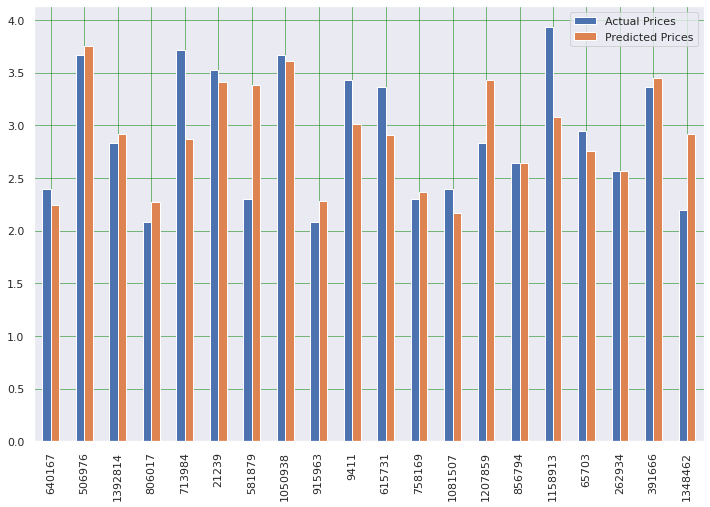

In [35]:
"""
Bar chart with predicted and actual prices of first 20 datapoints
"""

df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': preds_2})
_df = df.head(20)
_df.plot(kind = 'bar', figsize = (12,8))
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = 'green')
plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'black')
plt.show()

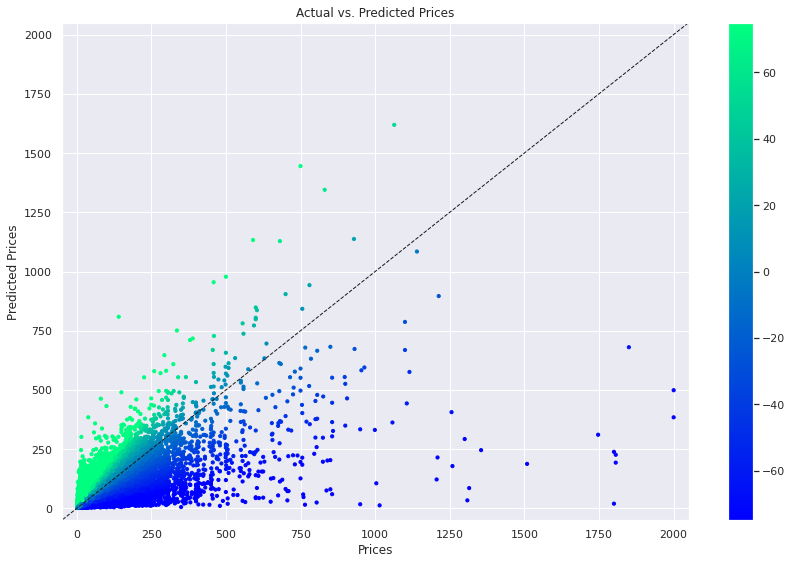

In [36]:
#image formatting
x_pred = np.expm1(preds)
x_true = np.expm1(y_test)
cm = plt.cm.get_cmap('winter')

# Normalized prediction error clipped so the color-coding covers -75% to 75% range
x_diff = np.clip(100 * ((x_pred - x_true) / x_true), -75, 75)

plt.figure(4, figsize=(12, 8))
plt.title('Actual vs. Predicted Prices')
plt.scatter(x_true, x_pred, c=x_diff, s=10, cmap=cm)
plt.colorbar()
plt.plot([x_true.min() - 50, x_true.max() + 50], [x_true.min() - 50, x_true.max() + 50], 'k--', lw=1)
plt.xlabel('Prices')
plt.ylabel('Predicted Prices')
plt.xlim(-50, 2050)
plt.ylim(-50, 2050)
plt.tight_layout()
plt.show()

### Fully connected neural network with 9 hidden layers

In [24]:
def mlp_regr_2(X_train, y_train, X_test, y_test):
    
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_val = y_scaler.transform(y_test.values.reshape(-1, 1))

    model_in = Input(shape = (363097,), dtype = 'float32', sparse = True)
    out = Dense(1024, activation='relu')(model_in)
    out = Dropout(0.2)(out)
    out = Dense(512, activation='relu')(out)
    out = Dropout(0.2)(out)
    out = Dense(256, activation='relu')(out)
    out = Dense(128, activation='relu')(out)
    out = Dense(64, activation='relu')(out)
    out = Dense(32, activation='relu')(out)
    out = Dense(16, activation='relu')(out)
    model_out = Dense(1)(out)
    
    model = Model(model_in, model_out)
    
    model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate=0.001))
    
    model.summary()
    
    model.fit(X_train, y_train, batch_size = 1024, epochs = 20, verbose = 1, validation_data = (X_test, y_val), callbacks = callbacks)

    predictions = model.predict(X_test)[:, 0]

    y_pred = y_scaler.inverse_transform(predictions.reshape(-1, 1))[:, 0]
    
    return model, y_pred, get_rmsle(np.expm1(y_pred), np.expm1(y_test))

In [25]:
regr_2, preds_2, err_2 = mlp_regr_2(train_data, y_train, test_data, y_test)

print('RMSLE: ', err_2)

#saves the model weights
regr_2.save_weights('model-2.h5')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 363097)]          0         
_________________________________________________________________
dense (Dense)                (None, 1024)              371812352 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

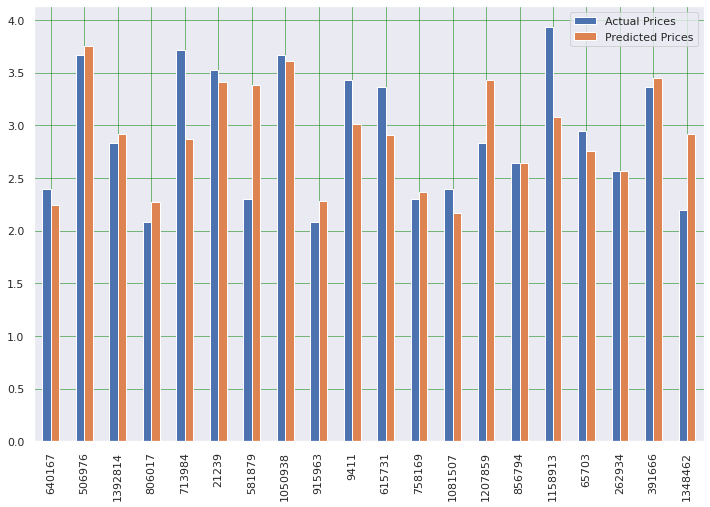

In [26]:
df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': preds_2})
_df = df.head(20)
_df.plot(kind = 'bar', figsize = (12,8))
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = 'green')
plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'black')
plt.show()

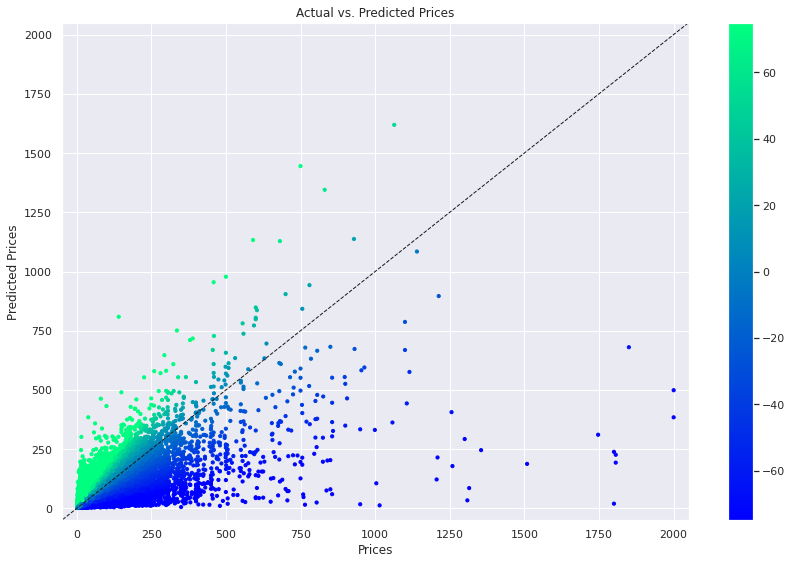

In [27]:
#image formatting
x_pred = np.expm1(preds_2)
x_true = np.expm1(y_test)
cm = plt.cm.get_cmap('winter')

# Normalized prediction error clipped so the color-coding covers -75% to 75% range
x_diff = np.clip(100 * ((x_pred - x_true) / x_true), -75, 75)

plt.figure(4, figsize=(12, 8))
plt.title('Actual vs. Predicted Prices')
plt.scatter(x_true, x_pred, c=x_diff, s=10, cmap=cm)
plt.colorbar()
plt.plot([x_true.min() - 50, x_true.max() + 50], [x_true.min() - 50, x_true.max() + 50], 'k--', lw=1)
plt.xlabel('Prices')
plt.ylabel('Predicted Prices')
plt.xlim(-50, 2050)
plt.ylim(-50, 2050)
plt.tight_layout()
plt.show()

### Ensemble with weights manually selected

In [37]:
"""
Giving 35% weightage to model_1 predictions and 75% to model_2
"""
w = 0.35

predictions = (w * preds) + ((1-w) * preds_2)

err = get_rmsle(np.expm1(y_test), np.expm1(predictions))

print('RMSLE : ', err)

RMSLE :  0.4105748240022382


## Conclusions/Observations

In [61]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "RMSLE"]

x.add_row(["XGB Regrssor", 0.487])
x.add_row(["Ridge Regressor", 0.481])
x.add_row(["LGBM Regressor", 0.460])
x.add_row(["Ensemble of XGB, Ridge and LGBM", 0.444])
x.add_row(["Stacking Ensemble of 3 Ridge Regressors with different alpha's", 0.444])
x.add_row(["NN 1", 0.419])
x.add_row(["NN 2", 0.420])
x.add_row(["Ensemble of NN1, NN2", 0.410])

print(x)

+----------------------------------------------------------------+-------+
|                             Model                              | RMSLE |
+----------------------------------------------------------------+-------+
|                          XGB Regrssor                          | 0.487 |
|                        Ridge Regressor                         | 0.481 |
|                         LGBM Regressor                         |  0.46 |
|                Ensemble of XGB, Ridge and LGBM                 | 0.444 |
| Stacking Ensemble of 3 Ridge Regressors with different alpha's | 0.444 |
|                              NN 1                              | 0.419 |
|                              NN 2                              |  0.42 |
|                      Ensemble of NN1, NN2                      |  0.41 |
+----------------------------------------------------------------+-------+


## Submission

Submission to kaggle was the ensemble of MLPs

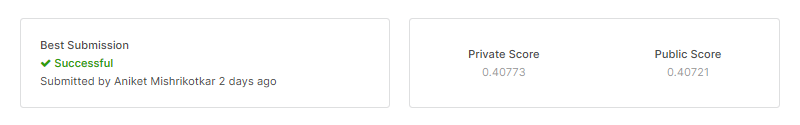

In [4]:
Image('Score.png')

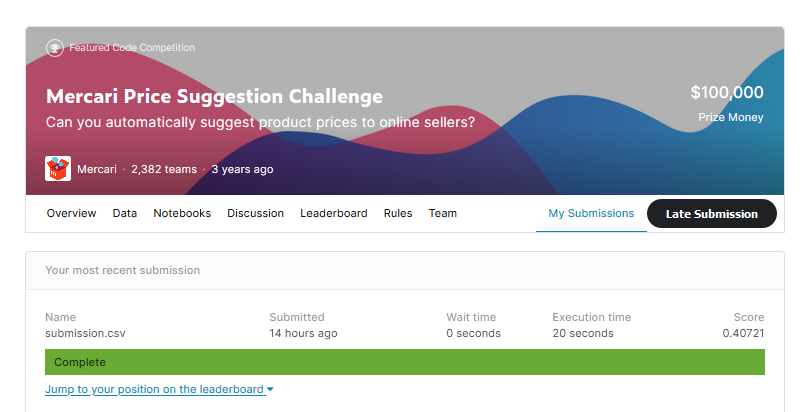

In [5]:
Image('Submission.png')

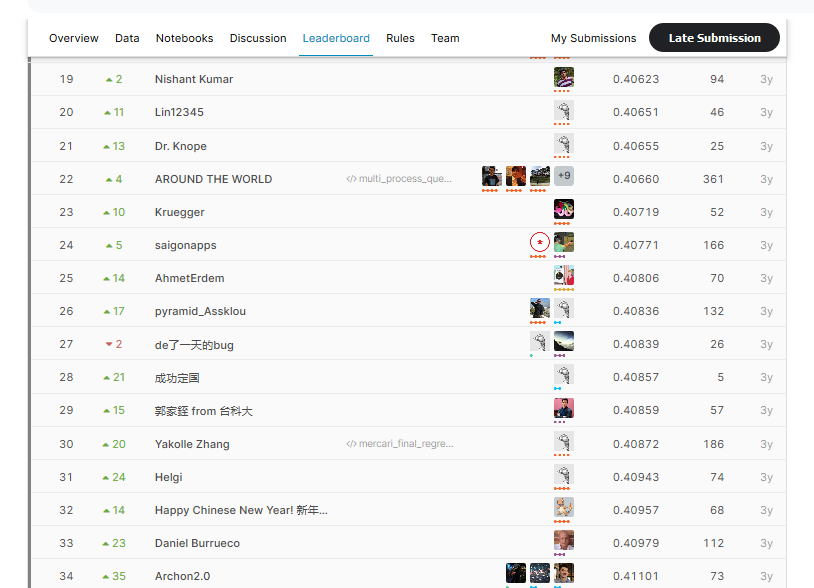

In [6]:
Image('Leaderboard.png')

- The score of 0.40721 on test_stg2.tsv puts us on number 23 out of 2382 submissions

## References

1. 1st Place Solution https://www.kaggle.com/c/mercari-price-suggestion-challenge/discussion/50256
2. 1st Place Solutionn Code https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
3. Keras Guides https://keras.io/guides/training_with_built_in_methods/
4. Fullstack.ai https://github.com/xadrianzetx/fullstack.ai
5. Airbnb Blog https://medium.com/airbnb-engineering/using-machine-learning-to-predict-value-of-homes-on-airbnb-9272d3d4739d
6. Stanford Project https://cs230.stanford.edu/files_winter_2018/projects/6940447.pdf
7. Youtube video of winners https://www.youtube.com/watch?v=QFR0IHbzA30
8. Gradient Boosting https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

In [43]:
####

In [44]:
####